## Imports 
Für die Durchführung der Zeitreihenanalyse der Sterblichkeit wir die Skriptsprache Python werden. Die verwendeten Bibliotheken Pandas, numpy sowie sklearn wurden verwendent um die Daten aufzubereiten und diese anschließend auswerten zu kommen. Die grafische Visualisierung wurde mittels Seaborn realsiert. Seaborn ist eine Python-Datenvisualisierungsbibliothek, die auf matplotlib basiert. Sie bietet eine High-Level-Schnittstelle zum Zeichnen attraktiver und informativer statistischer Grafiken ähnlich wie in R.

In [80]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
hs_blau = "#22376f"

## Daten
Die Verwendeten Daten stammen von dem Deutschen statistischen Bundesamt (DESTATIS) und aus der Bundesanstalt Statistik Österreich(STAT). Für die Verarbeitung wurden die Daten im Excel Format aus den entsprechnenden Datenbanken der einzelnen Länder importiert und für die Bearbeitung der Fragestellung angepasst. Hierfür wurden Inhaltlich unrelevante Inhalte entfernt. 

Als Daten wurden die Sterbefälle der einzelnen Altersgruppen der Bundesländer Deutschland und Österreich  im Zeit vom 1990 bis 2021 verwendet. Außerdem wurden die Daten aus der Sonderauswertung der Destatis, welche die Fallzahlen der Sterbefälle nach Tagen, Wochen, Monaten und Altersgruppen von 2000-2021 genutzt. 

[Link zur Sterbefällen der DESTATIS Deutschland](https://www-genesis.destatis.de/genesis//online?operation=table&code=12613-0003&bypass=true&levelindex=0&levelid=1653983101039#abreadcrumb) 

[Link zur Sterbefällen der STATcube Österreich](https://statcube.at/statistik.at/ext/statcube/jsf/tableView/tableView.xhtml) 

[Link zur Sonderauswertung](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.html;jsessionid=781CD0C1625940234B84DDDE0AEC8B99.live741?nn=209016) 

In [81]:
#Daten über die Bevölkerung der einzelnen Länder
bevölkerung_deutschland = pd.read_excel(f"Data\\Daten_fuer_Deutschland\\12411-0012_complete.xlsx", index_col=0)
bevölkerung_österreich = pd.read_excel(f"Data\\Daten_fuer_Oesterreich\\table_2022-05-29_19-20-56.xlsx", index_col=0).reset_index(drop=True)


#Daten für die Sterblichkeitsanalyse (Sterblichkeiten pro Monat)
sterbefälle_monat = pd.read_excel(f"Data\\Daten_fuer_Deutschland\\sonderauswertung-sterbefaelle_inkl_2021.xlsx", sheet_name='D_2016-2022_Monate_AG_Ins')
sterbefälle_monat = sterbefälle_monat[sterbefälle_monat.columns].replace(["-",".","X "],0)

#Daten für den Bundesländervergleich Deutschland 
sterbefälle_monat_fuer_bundeslaender_vgl = pd.read_excel(f"Data\\Daten_fuer_Deutschland\\sonderauswertung-sterbefaelle_groß.xlsx", sheet_name='BL_2016_2022_Monate_AG_Ins')
sterbefälle_monat_fuer_bundeslaender_vgl = sterbefälle_monat_fuer_bundeslaender_vgl[sterbefälle_monat_fuer_bundeslaender_vgl.columns].replace(["-",".","X "],0)
sterbefälle_monat_fuer_bundeslaender_vgl.loc[sterbefälle_monat_fuer_bundeslaender_vgl["Bundesland"]=="Baden-Württemberg"][["Bundesland", "Altersgruppe", "Insgesamt"]]


#Daten für den Ländervergleich Österreich 
österreich_sterbefälle_altersgruppen = pd.read_excel(f"Data\\Daten_fuer_Oesterreich\\gestorbene_seit_2006_nach_altersgruppen_bearbeitet.xlsx")
österreich_sterbefälle_altersgruppen = österreich_sterbefälle_altersgruppen[österreich_sterbefälle_altersgruppen.columns].replace(["-",".","X "],0)
österreich_sterbefälle_altersgruppen

österreich_sterbefälle_altersgruppen

,Nr.,Jahr,Alter,Männer,Frauen,Insgesamt
0,1,2006,Insgesamt,34757,39538,74295
1,2,2006,0 bis 14 Jahre,261,186,447
2,3,2006,15 bis 19 Jahre,181,62,243
3,4,2006,20 bis 24 Jahre,222,75,297
4,5,2006,25 bis 29 Jahre,183,75,258
...,...,...,...,...,...,...
250,251,2020,65 bis 69 Jahre,3607,2082,5689
251,252,2020,70 bis 74 Jahre,5069,3215,8284
252,253,2020,75 bis 79 Jahre,6970,5265,12235
253,254,2020,80 bis 84 Jahre,7809,7072,14881


## 1. Aufarbeitung der Daten 

Im folgenden Abschnit werden die Altersgruppen der Deutschenbevölkerung von den über 90 Jährigen zusammengefasst. Dies dient zur besseren Aufteilung der verschiedenen Altersgruppen. In der Regel werden diese Ziffern auf der Basis von 5-Jahres-Altersgruppen gebildet. Es wird
unterstellt, dass die Altersverteilung innerhalb von 5-Jahresgruppen nicht nennenswert zwischen verschiedenen Populationen differiert. Unter dieser Annahme können altersspezifische Sterbeziffern einem direkten Vergleich für verschiedene Bevölkerungsgruppen, Regionen oder
Zeiträume unterzogen werden. 

Die Gruppiert wird innerhalb zweier For-Schleifen realisiert. Hierbei dient die erste Scheifel für das durchlaufen der einzlenen Jahres, die zweite Schleife wird für das zusammenfassen der einzelnen Altersgruppen in dem jeweiligem Jahr benötigt.


In [82]:
#Sterbefälle einteilen Deutschland
#bildet summe aus gruppe 90-95 und gruppe ü 95, ersetzt die 90-95 row damit, benennt sie um und dropt die ü95 reihe.
new_row = (sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="90-95"]) + (sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="95 u. mehr"])
age_90_95 = sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="90-95"]
mehr_95 = sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="95 u. mehr"]

new_row = age_90_95.iloc[0,3:] + mehr_95.iloc[0,3:]
index_95 = list(age_90_95.index)
index_mehr = list(mehr_95.index)

for i in range (len(index_95)):
    new_row = age_90_95.iloc[i,3:] +mehr_95.iloc[i,3:]
    sterbefälle_monat.loc[index_95[i], "Januar":] = new_row
    sterbefälle_monat.drop(index_mehr[i], inplace=True)


sterbefälle_monat['Alter'].replace({'90-95': '90<'}, inplace = True)
sterbefälle_monat = sterbefälle_monat.rename(columns={'Januar': 1,'Februar': 2,'März': 3,'April': 4,'Mai': 5,'Juni': 6,'Juli': 7,'August': 8,'September': 9,'Oktober': 10,'November': 11,'Dezember': 12})
sterbefälle_monat


#Sterbefälle einteilen Östereich
#Auswählen der gewünschten Spalten
alter_85_bis_89 = bevölkerung_österreich.loc[bevölkerung_österreich["Altersgruppen"]=="85 bis 89 Jahre"]
alter_90_bis_94 = bevölkerung_österreich.loc[bevölkerung_österreich["Altersgruppen"]=="90 bis 94 Jahre"]
alter_95_bis_99 = bevölkerung_österreich.loc[bevölkerung_österreich["Altersgruppen"]=="95 bis 99 Jahre"]
alter_100_und_mehr = bevölkerung_österreich.loc[bevölkerung_österreich["Altersgruppen"]=="100 Jahre und älter"]

#Aufsummieren der Zeilen
index_85_bis_89 = list(alter_85_bis_89.index)
index_90_bis_94 = list(alter_90_bis_94.index)
index_95_bis_99 = list(alter_95_bis_99.index)
index_100_und_mehr = list(alter_100_und_mehr.index)

for i in range (len(index_85_bis_89)):
    new_row = alter_85_bis_89.iloc[i,2:] + alter_90_bis_94.iloc[i,2:] + alter_95_bis_99.iloc[i,2:] + alter_100_und_mehr.iloc[i,2:]
    bevölkerung_österreich.loc[index_85_bis_89[i], "männlich":] = new_row
    bevölkerung_österreich.drop([index_90_bis_94[i],index_95_bis_99[i],index_100_und_mehr[i]], inplace=True)

bevölkerung_österreich['Altersgruppen'].replace({'85 bis 89 Jahre': '85<'}, inplace = True)
bevölkerung_österreich

,Jahr,Altersgruppen,männlich,weiblich,Insgesamt
0,2002,bis 14 Jahre,689766,656006,1345772
1,2002,15 bis 19 Jahre,246631,235420,482051
2,2002,20 bis 24 Jahre,244102,236895,480997
3,2002,25 bis 29 Jahre,263353,264940,528293
4,2002,30 bis 34 Jahre,331851,327188,659039
...,...,...,...,...,...
392,2021,70 bis 74 Jahre,189301,222212,411513
393,2021,75 bis 79 Jahre,149676,192335,342011
394,2021,80 bis 84 Jahre,115999,162246,278245
395,2021,85<,74328,149532,223860


##### Aufteilung der Altersgruppen in 0-15, 15-30, 30-35, ..., 85-90, 90+ für Deutschland
**Anmerkung:** Die Daten der Bevölkerung von Österreich müssen nicht gruppiert werden, da diese bereits in die verschiedenen Altergruppen gruppiert in der STATEcube vorliegen.
Hierbei ist jedoch zu beachten, dass die Altersgrenze der Daten aus Österreich bei <85 liegt.  

In [83]:
#alle Altersgruppen einteilen
rows = []
x = 0
j = 0
for k in range (1 ,33): 
    x=0
    for i in range(0, 92):
        k2 = k*91
        if i == 0 and k == 1:
            bevölkerungs_anzahl = bevölkerung_deutschland.loc[bevölkerung_deutschland.index[0]]["Gesamt"] #Gesamtbevölkerung je altersgruppe
        if i == 0 and k != 1:
            bevölkerungs_anzahl = bevölkerung_deutschland.loc[bevölkerung_deutschland.index[i+(k-1)*92]]["Gesamt"]
        else:
            bevölkerungs_anzahl = bevölkerung_deutschland.loc[bevölkerung_deutschland.index[i+((k-1)*92)]]["Gesamt"]

        if ( i < 15):
            x += bevölkerungs_anzahl
            if (i == 14):
                rows.append([1990+k-1,"0 - "+"<{}".format(i+1), x])
                x = 0   

        elif (i >= 15 and  i < 30):
    
            x += bevölkerungs_anzahl
            if i == 29:
                rows.append([1990+k-1,(str(i-14)+" - <"+str(i+1)), x])
                x = 0

        elif (i >= 30 and  i < 90):
            j += 1
            x += bevölkerungs_anzahl
            if j == 5:
                rows.append([1990+k-1,(str(i-4)+" - <"+str(i+1)), x])
                j = 0
                x = 0

        elif i == 90:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"90=<", x])
            x = 0

        elif i == 91:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"Gesamt", x])
            x=0
       
df_aufgeteilte_altersgruppen = pd.DataFrame(rows, columns=["Jahr","Alter", "Anzahl"])

#_________________________________________________________________________________________________________________________________________________________________________________________________________________

#Einteilung der Altersgruppen für Österreich damit Altersgruppierung den Daten von der STATEcube gleicht
rows = []
x = 0
j = 0
for k in range (1 ,32):
    x=0
    for i in range(0, 92):
        k2 = k*91
        if i == 0 and k == 1:
            bevölkerungs_anzahl = bevölkerung_deutschland.loc[bevölkerung_deutschland.index[0]]["Gesamt"] #Gesamtbevölkerung je altersgruppe
        if i == 0 and k != 1:
            bevölkerungs_anzahl = bevölkerung_deutschland.loc[bevölkerung_deutschland.index[i+(k-1)*92]]["Gesamt"]
        else:
            bevölkerungs_anzahl = bevölkerung_deutschland.loc[bevölkerung_deutschland.index[i+((k-1)*92)]]["Gesamt"]

        if ( i < 15):
            x += bevölkerungs_anzahl
            if (i == 14):
                rows.append([1990+k-1,"0 - "+"<{}".format(i+1), x])
                x = 0

        elif (i >= 15 and  i < 85):
            j += 1
            x += bevölkerungs_anzahl
            if j == 5:
                rows.append([1990+k-1,(str(i-4)+" - <"+str(i+1)), x])
                j = 0
                x = 0

        elif (i >= 85 and  i <= 90):
            x += bevölkerungs_anzahl
            if i == 90:
                rows.append([1990+k-1,"85<", x])
                x = 0

        elif i == 91:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"Gesamt", x])
            x=0


alters_gruppen_de_fuer_at = pd.DataFrame(rows, columns=["Jahr","Alter", "Anzahl"])
alters_gruppen_de_fuer_at


,Jahr,Alter,Anzahl
0,1990,0 - <15,12937503
1,1990,15 - <20,4369092
2,1990,20 - <25,6318534
3,1990,25 - <30,7004877
4,1990,30 - <35,6249072
...,...,...,...
522,2020,70 - <75,3968070
523,2020,75 - <80,3468028
524,2020,80 - <85,3430502
525,2020,85<,2505932


## 2. Altersbereinigung von Daten
Für die Untersuchung der Sterblichkeit in Deutschland gibt verschiedene Wege, die den verzerrenden Effekt unterschiedlicher Altersstrukturen auf Sterbeziffern und Krankheitsraten umgehen. Der direkteste, aber nicht unbedingt gangbarste Weg ist die Berechnung **altersspezifischer rohe Sterbeziffern**. Diese geben die Anzahl der Gestorbenen einer Altersgruppe je 100 000 Einwohner der gleichen Altersgruppe an.


$$ \operatorname {\text{Rohe Sterberate}} = \frac{\text{Anzahl Verstorbene}}{\text{Gesamtpopulation}} \cdot100.000 $$

Das Verfahren der **direkten Alterstandardisierung** bezieht die zu untersuchenden altersspezifischen Raten, beispielsweise die Mortalitätsraten, auf eine (frei wählbare) „Standardpopulation“. Die Mortalitätsraten der einzelnen Altersgruppen in der beobachteten Bevölkerung werden hierbei mit den Bevölkerungsanteilen der Standardpopulation gewichtet entsprechend der Formel:


$$ \operatorname {\text{Altersbereinigte Sterblichkeit}} = \frac{\sum\text{ASX}\cdot\text{subx}}{\sum\text{ASX}}$$

+ ASX = Anzahl Personen der Standardbevölkerung in der Altersgruppe x
+ subx = Sterberate untersuchte Bevölkerung in der Altersgruppe x
+ große Buchstaben = Standardbevölkerung
+ kleine Buchstaben = untersuchte Bevölkerung






wobei **ASX** die Zahl der Personen in der Altersgruppe **x** der Standardbevölkerung ist, **subx** für die altersspezifischen Mortalitätsraten je 100000 der untersuchten Bevölkerung steht und Σ die Summation über allen Altersgruppen anzeigt. (In dieser und den folgenden Formeln beziehen sich großgeschriebene Variablen auf die Standardbevölkerung, kleingeschriebene auf die Ziel population. 

Hierbei ist zu beachten, dass altersstandardisierte Raten fiktive Kennziffern darstellen, die nur als Vergleichsgrößen zwischen verschiedenen Populationen dienen sollten. Wie weit diese fiktiven Werte von den rohen, unbereinigten Raten abweichen, wird durch die Wahl der Standardbevölkerung entschieden. Theoretisch ist die Wahl dieser Population beliebig, vorausgesetzt, man benutzt bei allen Vergleichen immer dieselbe Standardpopulation. In der Praxis sollte man einen Bevölkerungsstandard vorziehen, der sich am Aufbau der untersuchten Bevölkerungsgruppe orientiert. So wird erreicht, dass der Vergleich nicht zu artifiziell wirkt und eine gewisse Interpretationsmöglichkeit der standardisierten Ziffer erhalten bleibt.


#### Festlegen der Standardbevölkerung für die direkte Altersstandatisierung
Für die Berechnung der Alterbereinigung muss eine Standardbevölkerung festgelegt werden. In unserem Fall verwenden wir die Deutsche Bevölkerung aus dem Jahr 2020.
Um die Altersstandardisierung auch für die Daten aus Österreich anwenden können muss noch eine zweite Standardbevölkerung gewählt werden. 

Dabei handelt es sich ebenfalls um die Deutsche Bevölkerung aus dem Jahr 2020, jedoch mit kleineren Altersgruppen.

**Wichtig: Es muss für die Altersstandatisierung jeweils die gleiche Bevölkerung verwendet werden, um die Daten vergleichen zu können.**

In [84]:
standard_bevölkerung_de = df_aufgeteilte_altersgruppen.loc[df_aufgeteilte_altersgruppen["Jahr"]==2020]
standard_bevölkerung_fuer_at = alters_gruppen_de_fuer_at.loc[alters_gruppen_de_fuer_at["Jahr"]==2020]
standard_bevölkerung_de

,Jahr,Alter,Anzahl
480,2020,0 - <15,11477800
481,2020,15 - <30,13340204
482,2020,30 - <35,5581088
483,2020,35 - <40,5290876
484,2020,40 - <45,5034888
485,2020,45 - <50,5035860
486,2020,50 - <55,6487224
487,2020,55 - <60,6817318
488,2020,60 - <65,5818137
489,2020,65 - <70,4899104


#### Berechnung der rohen Sterberate
Die Berechnung der rohen Sterblichkeit wird mittels zweier For-Schleifen realisiert, hierbei dient die äußere Schleifen für das durchlaufen der Jahr. Anhand der inneren For-Schleife wird auf die einzlenen Bevölkerungsgruppen in dem DataFrame zugegriffen. Anschließend wird die Differenz zwischen der jeweiligen Altersgruppe und derem Gesamtpopulation der ermittlelt und mit dem Faktor von 100.000 multiplizerit.

**Rohe Sterberate für Deutschland**

In [85]:
#rohe sterberate
#loop über jahre
sterberaten_roh_de = []
for n in range(0,22):
    z_de = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2021-n)]
    sterberate_gesamt_de = 0

    # gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[15]][2]
    gesamt_bev_de = df_aufgeteilte_altersgruppen.loc[df_aufgeteilte_altersgruppen["Jahr"]==2021-n]["Anzahl"].reset_index(drop= True)

    #loop über altersgruppen
    for i in range(1,16):
        mri_de = ((z_de.loc[z_de.index[i]]["Insgesamt"]) / gesamt_bev_de[15]) * 100000  #sterberate je altersgruppe
        sterberate_gesamt_de += mri_de


    sterberaten_roh_de.append([2021-n, sterberate_gesamt_de])
    sterberate_gesamt_de = 0

sterberaten_roh_de = pd.DataFrame(sterberaten_roh_de, columns=["Jahr", "Sterberate_Roh"])
sterberaten_roh_de


,Jahr,Sterberate_Roh
0,2021,1227.1327
1,2020,1185.2223
2,2019,1129.6828
3,2018,1150.1844
4,2017,1126.0255
5,2016,1103.8303
6,2015,1125.8805
7,2014,1069.4364
8,2013,1106.6647
9,2012,1079.9075


**Rohe Sterberate für Deutschland Saisonal bereinigt**

In [86]:
sterberaten_roh_de_saisonal = []
for n in range(0,22):
    sterberate_gesamt_saisonal = 0
    z_vor_jahr_saisonal = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2022-(n+1))].reset_index(drop= True) #2019
    z_saisonal = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2022-n)].reset_index(drop= True) #2020
    gesamt_bev_vor_jahr_saisonal = df_aufgeteilte_altersgruppen.loc[df_aufgeteilte_altersgruppen["Jahr"]==2022-(n+1)]["Anzahl"].reset_index(drop= True)

    #loop über altersgruppen
    for age in range(1,16,1):
        todeszahlen_sessional_ingesamt = 0
        for monat in range (1,13):
            if monat <= 6:
                todeszahlen_sessional_ingesamt += z_vor_jahr_saisonal[monat+6][age]
            else:
                todeszahlen_sessional_ingesamt += z_saisonal[monat-6][age]

        mri_saisonal = (todeszahlen_sessional_ingesamt / gesamt_bev_vor_jahr_saisonal[15]) * 100000  #sterberate je altersgruppe #2019 Bevoelkerung
        sterberate_gesamt_saisonal += mri_saisonal

    sterberaten_roh_de_saisonal.append([2022-(n+1), sterberate_gesamt_saisonal])
    sterberate_gesamt_saisonal = 0

sterberaten_roh_de_saisonal = pd.DataFrame(sterberaten_roh_de_saisonal, columns=["Jahr", "Sterberate_Roh"])
sterberaten_roh_de_saisonal

,Jahr,Sterberate_Roh
0,2021,1131.0002
1,2020,1215.8952
2,2019,1135.4723
3,2018,1123.7134
4,2017,1142.0222
5,2016,1136.6605
6,2015,1094.2178
7,2014,1137.2833
8,2013,1056.6458
9,2012,1116.5228


Da wir im späteren Verlauf des Notebook noch eine Vergleich der Sterblichkeit zwischen den Ländern Österreich und Deutschland ziehen möchten, wird für Österreich ebenflass die rohe Sterberate berechnet.

**Rohen Sterberate für Österreich**



In [87]:
#rohe sterberate
#loop über jahre
sterberaten_roh_at = []
for n in range(0,15):
    z = österreich_sterbefälle_altersgruppen.loc[(österreich_sterbefälle_altersgruppen["Jahr"]==2020-n)].reset_index(drop= True)
    sterberate_gesamt = 0

    gesamt_bev = bevölkerung_österreich.loc[bevölkerung_österreich["Jahr"]==2020-n]["Insgesamt"].reset_index(drop= True)
    #loop über altersgruppen
    for i in range(1,17):
        mri = ((z.loc[z.index[i]]["Insgesamt"]) / gesamt_bev[16]) * 100000  #sterberate je altersgruppe
        sterberate_gesamt += mri


    sterberaten_roh_at.append([2020-n, sterberate_gesamt])
    sterberate_gesamt = 0

sterberaten_roh_at = pd.DataFrame(sterberaten_roh_at, columns=["Jahr", "Sterberate_Roh"])
sterberaten_roh_at

,Jahr,Sterberate_Roh
0,2020,1029.0792
1,2019,941.2814
2,2018,951.8529
3,2017,949.1768
4,2016,927.1797
5,2015,967.6612
6,2014,919.7693
7,2013,940.9290
8,2012,944.7533
9,2011,913.1642


#### Direkte Altersbereinigte/Altersstandardisierung unter der Verwendung der Deutschen Standardbevölkerung von 2020

Bei der Berechnung der direkten Altersstandardisierung wird also die Sterberate jeder Altersgruppe mit der Zahl der Personen in der entsprechen den Gruppe der Standardpopulation multipliziert. Die Produkte werden summiert und durch die Gesamtpersonenzahl der Standardpopulation dividiert. Die rohen Sterberaten, beispielsweise verschiedener Bundesländer, werden demnach so neuberechnet, als wäre die Altersverteilung aller Bundesländer identisch mit der gewählten Standardbevölkerung.


**Direkte Altersstandardisierung für Deutschland**

In [88]:
#altersbereinigt
sterberaten_bereinigt_de = []
#loop über jahre
for n in range(0,22):
    z_de = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2021-n)]
    q_de = df_aufgeteilte_altersgruppen.loc[df_aufgeteilte_altersgruppen["Jahr"]==2021-n]
    erg_sum_de = 0
    gesamt_bev_de = standard_bevölkerung_de.loc[standard_bevölkerung_de.index[15]][2]


    sum_de = 0
    #loop über Altersgruppen
    for i in range(0,15):

        asx_de = standard_bevölkerung_de.loc[standard_bevölkerung_de.index[i]][2] #bevölkerung je altersgruppe Standardbevölkerung
        bevölkerung_grp_de = q_de.loc[q_de.index[i]][2] #größe Bevölkerungsruppe untersuchte Bevölkerung
        subx_de = ((z_de.loc[z_de.index[i+1]]["Insgesamt"]) / bevölkerung_grp_de) * 100000 #sterberate je altersgruppe
        sum_de += (asx_de * subx_de)

    erg_de = sum_de / gesamt_bev_de
    erg_sum_de += erg_de

    #print(2020-n, "Altersbereinigt:",erg_sum)
    sterberaten_bereinigt_de.append([2021-n, erg_sum_de])

sterberaten_bereinigt_de = pd.DataFrame(sterberaten_bereinigt_de, columns=["Jahr", "Sterberate_bereinigt"])
sterberaten_bereinigt_de

,Jahr,Sterberate_bereinigt
0,2021,1213.4906
1,2020,1185.2223
2,2019,1149.6736
3,2018,1197.3936
4,2017,1188.1074
5,2016,1179.4441
6,2015,1224.6695
7,2014,1173.9001
8,2013,1245.7843
9,2012,1234.3103


**Direkte Altersstandardisierung für Deutschland saisonal**

In [89]:
#altersbereinigt
sterberaten_bereinigt_de_saisonal = []

#loop über jahre
for n in range(0,21):
    erg_sum = 0
    sum = 0
    z_vor_jahr = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2022-(n+1))].reset_index(drop= True) #2020
    z = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2022-n)].reset_index(drop= True) #2021
    gesamt_bev_vor_jahr = df_aufgeteilte_altersgruppen.loc[df_aufgeteilte_altersgruppen["Jahr"]==2021-(n+1)]["Anzahl"].reset_index(drop= True) # new_df eingeteilte Altergruppen

    q = df_aufgeteilte_altersgruppen.loc[df_aufgeteilte_altersgruppen["Jahr"]==2021-n] #alle Jahre
    gesamt_bev = standard_bevölkerung_de.loc[standard_bevölkerung_de.index[15]][2]
    #loop über Altersgruppen
    for i in range(1,16,1):
        todeszahlen_sessional_ingesamt = 0
        for monat in range (1,13):
            if monat <= 6:
                todeszahlen_sessional_ingesamt += z_vor_jahr[monat+6][i]
            else:
                todeszahlen_sessional_ingesamt += z[monat-6][i]

        asx = standard_bevölkerung_de.loc[standard_bevölkerung_de.index[i-1]][2] #bevölkerung je altersgruppe Standardbevölkerung
        bevölkerung_grp = q.loc[q.index[i-1]][2] #größe Bevölkerungsruppe untersuchte Bevölkerung
        subx = (todeszahlen_sessional_ingesamt / bevölkerung_grp) * 100000 #sterberate je altersgruppe
        sum += (asx * subx)

    erg = sum / gesamt_bev
    erg_sum += erg
    sterberaten_bereinigt_de_saisonal.append([2022-(n+1), erg_sum])

sterberaten_bereinigt_de_saisonal = pd.DataFrame(sterberaten_bereinigt_de_saisonal, columns=["Jahr", "Sterberate_bereinigt"])
sterberaten_bereinigt_de_saisonal

,Jahr,Sterberate_bereinigt
0,2021,1117.4642
1,2020,1215.8952
2,2019,1156.6015
3,2018,1170.6376
4,2017,1206.2081
5,2016,1216.6074
6,2015,1190.3150
7,2014,1251.2526
8,2013,1187.3506
9,2012,1277.4700


**Direkte Altersstandardisierung für Österreich**

In [90]:
#altersbereinigt
sterberaten_bereinigt_at = [] 
#loop über jahre
for n in range(0,15):
    z_at = österreich_sterbefälle_altersgruppen.loc[(österreich_sterbefälle_altersgruppen["Jahr"]==2020-n)] #Österreich
    q_at = bevölkerung_österreich.loc[bevölkerung_österreich["Jahr"]==2020-n] #Österreich
    gesamt_bev_at = standard_bevölkerung_fuer_at.loc[standard_bevölkerung_fuer_at.index[16]][2] #Deutsch
    erg_sum_at = 0
    sum_at = 0

    #loop über Altersgruppen
    for i in range(0,16):
        asx_at = standard_bevölkerung_fuer_at.loc[standard_bevölkerung_fuer_at.index[i]][2] #bevölkerung je altersgruppe Standardbevölkerung
        bevölkerung_grp = q_at.loc[q_at.index[i]][4] #größe Bevölkerungsruppe untersuchte Bevölkerung
        subx_at = ((z_at.loc[z_at.index[i+1]]["Insgesamt"]) / bevölkerung_grp) * 100000 #sterberate je altersgruppe
        sum_at += (asx_at * subx_at)

    erg_at = sum_at / gesamt_bev_at
    erg_sum_at += erg_at

    sterberaten_bereinigt_at.append([2020-n, erg_sum_at])

sterberaten_bereinigt_at = pd.DataFrame(sterberaten_bereinigt_at, columns=["Jahr", "Sterberate_bereinigt"])
sterberaten_bereinigt_at

,Jahr,Sterberate_bereinigt
0,2020,1208.3864
1,2019,1121.5188
2,2018,1142.9918
3,2017,1149.6628
4,2016,1132.5231
5,2015,1187.6344
6,2014,1142.8835
7,2013,1183.2664
8,2012,1199.7292
9,2011,1181.0621


#### Grafische Visualisierung der rohe vs. alteresbereinigte Sterblichkeit 
**Für Deutschland**

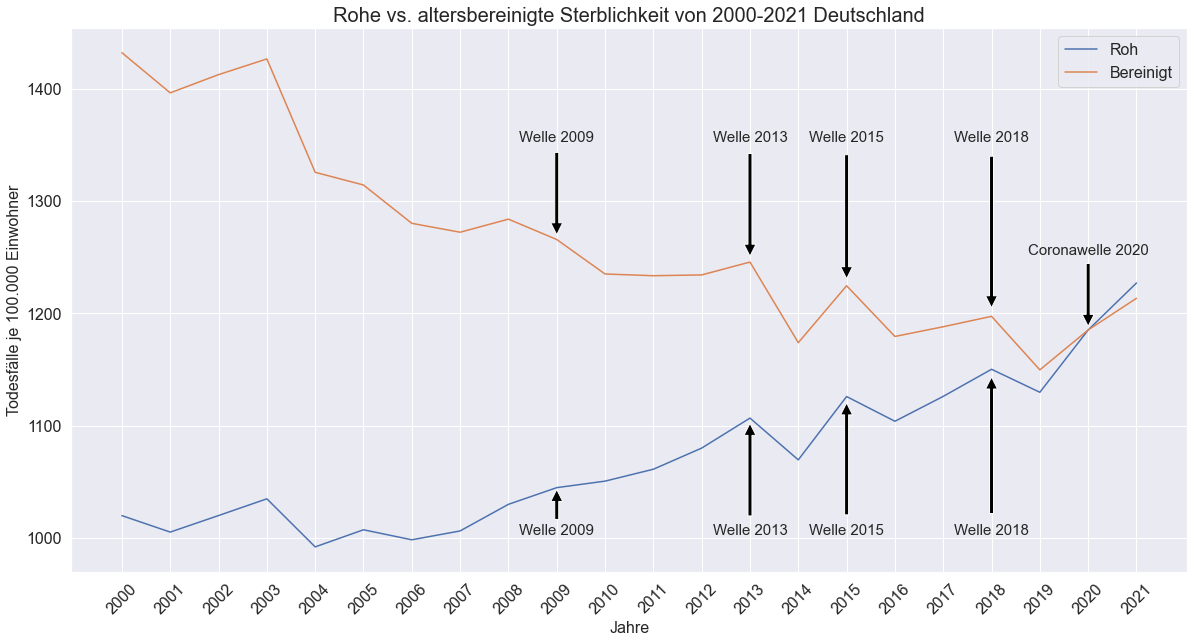

In [91]:
xticks = [i for i in range(2000,2022)]

ax = sns.lineplot(x="Jahr",  y='Sterberate_Roh', data=sterberaten_roh_de)
sns.lineplot(ax=ax, x="Jahr",  y='Sterberate_bereinigt', data=sterberaten_bereinigt_de)
plt.legend(labels=['Roh','Bereinigt'],fontsize= 16)
sns.set_theme(style="whitegrid")
plt.xticks(rotation=45)

grippe_wellen = [2009,2013,2015,2018,2020]

for weave in grippe_wellen:
    sel_year_raw = sterberaten_roh_de.loc[sterberaten_roh_de["Jahr"] == weave]
    raw_year = sel_year_raw.Jahr
    raw_death = sel_year_raw.Sterberate_Roh

    sel_year_cleaned = sterberaten_bereinigt_de.loc[sterberaten_bereinigt_de["Jahr"] == weave]
    cleaned_year = sel_year_cleaned.Jahr
    cleaned_death = sel_year_cleaned.Sterberate_bereinigt


    if  weave == 2020:
     ax.annotate("Coronawelle " + str(weave), xy=(raw_year, raw_death),xycoords='data', size = 15, xytext=(raw_year, 1250) , ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')
    else:
        ax.annotate("Welle "+str(weave), xy=(raw_year, raw_death), xycoords='data',xytext=(raw_year, 1000), size = 15,ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')

        ax.annotate("Welle " +str(weave), xy=(cleaned_year, cleaned_death),xycoords='data',xytext=(cleaned_year, 1350),size = 15, ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')


ax.set_ylabel("Todesfälle je 100.000 Einwohner", fontsize = 16)
ax.set_xlabel("Jahre", fontsize = 16)
ax.set_title("Rohe vs. altersbereinigte Sterblichkeit von 2000-2021 Deutschland",fontsize = 20)
plt.xticks(range(min(xticks), max(xticks)+1, 1), fontsize=16)
plt.yticks(fontsize=16)
plt.gcf().set_size_inches(20, 10)

**Für Deutschland saisonal**

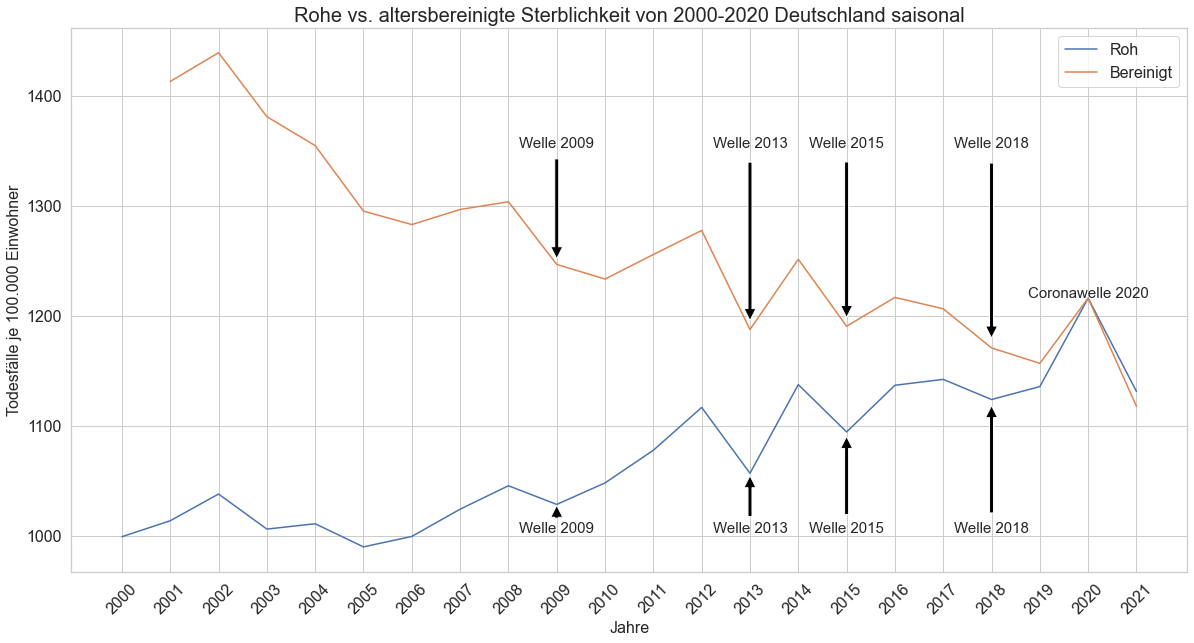

In [92]:
xticks = [i for i in range(2000,2022)]

ax = sns.lineplot(x="Jahr",  y='Sterberate_Roh', data=sterberaten_roh_de_saisonal)
sns.lineplot(ax=ax, x="Jahr",  y='Sterberate_bereinigt', data=sterberaten_bereinigt_de_saisonal)
plt.legend(labels=['Roh','Bereinigt'],fontsize= 16)
sns.set_theme(style="whitegrid")
plt.xticks(rotation=45)

# annotate lines
grippe_wellen = [2009,2013,2015,2018,2020]

for weave in grippe_wellen:
    sel_year_raw = sterberaten_roh_de_saisonal.loc[sterberaten_roh_de_saisonal["Jahr"] == weave]
    raw_year = sel_year_raw.Jahr
    raw_death = sel_year_raw.Sterberate_Roh

    sel_year_cleaned = sterberaten_bereinigt_de_saisonal.loc[sterberaten_bereinigt_de_saisonal["Jahr"] == weave]
    cleaned_year = sel_year_cleaned.Jahr
    cleaned_death = sel_year_cleaned.Sterberate_bereinigt
    if  weave == 2020:
     ax.annotate("Coronawelle " + str(weave), xy=(raw_year, raw_death),xycoords='data', size = 15,ha='center')
    else:
        ax.annotate("Welle "+str(weave), xy=(raw_year, raw_death), xycoords='data',xytext=(raw_year, 1000), size = 15,ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')

        ax.annotate("Welle " +str(weave), xy=(cleaned_year, cleaned_death),xycoords='data',xytext=(cleaned_year, 1350),size = 15, ha='center',arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')

ax.set_ylabel("Todesfälle je 100.000 Einwohner", fontsize = 16)
ax.set_xlabel("Jahre", fontsize = 16)
ax.set_title("Rohe vs. altersbereinigte Sterblichkeit von 2000-2020 Deutschland saisonal",fontsize = 20)
plt.xticks(range(min(xticks), max(xticks)+1, 1), fontsize=16)
plt.yticks(fontsize=16)

plt.gcf().set_size_inches(20, 10)

**Für Österreich**

(array([ 800.,  900., 1000., 1100., 1200., 1300., 1400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

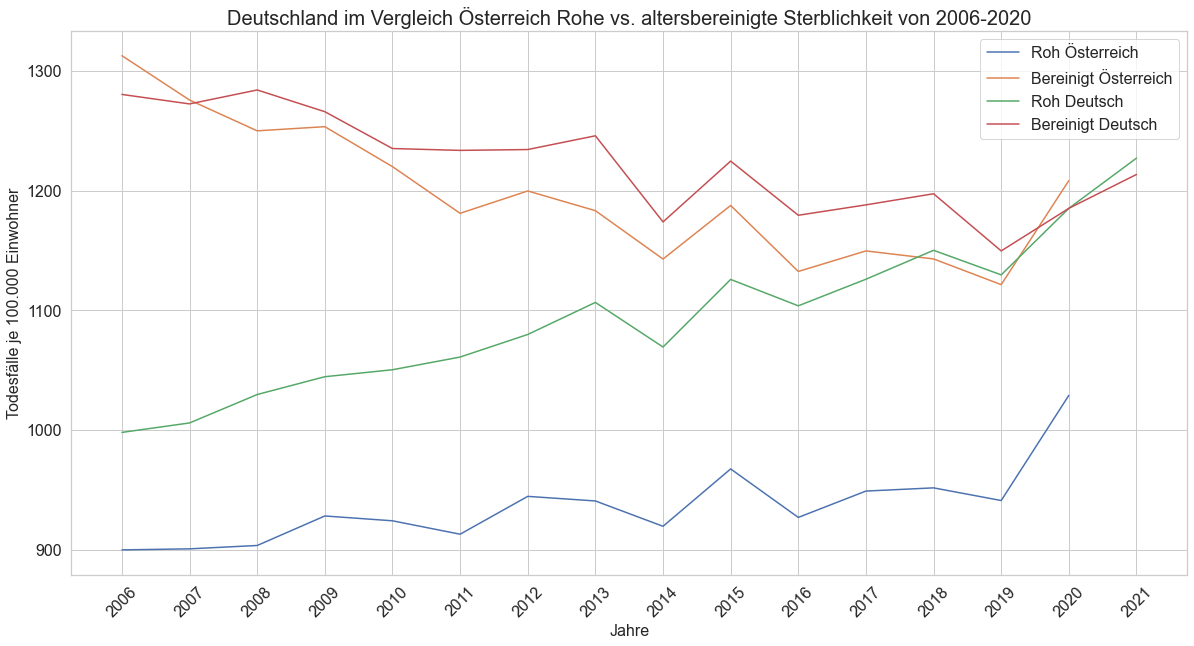

In [93]:
xticks = [i for i in range(2006,2022)]

ax = sns.lineplot(x="Jahr",  y='Sterberate_Roh', data=sterberaten_roh_at, label='oestereich_roh')
sns.lineplot(ax=ax, x="Jahr",  y='Sterberate_bereinigt', data=sterberaten_bereinigt_at, label='oestereich_bereingt')
sns.lineplot(ax=ax, x="Jahr",  y='Sterberate_Roh', data=sterberaten_roh_de.loc[sterberaten_roh_de["Jahr"]>2005], label='deutsch_roh')
sns.lineplot(ax=ax, x="Jahr",  y='Sterberate_bereinigt', data=sterberaten_bereinigt_de.loc[sterberaten_bereinigt_de["Jahr"]>2005], label='deutsch_roh') #sterberaten_roh_de.loc[sterberaten_roh_de["Jahr"]>2005]
plt.legend(labels=['Roh Österreich','Bereinigt Österreich', 'Roh Deutsch','Bereinigt Deutsch'],fontsize= 16)
sns.set_theme(style="whitegrid")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

grippe_wellen = [2009,2013,2015,2018,2020]

ax.set_ylabel("Todesfälle je 100.000 Einwohner", fontsize = 16)
ax.set_xlabel("Jahre", fontsize = 16)
ax.set_title("Deutschland im Vergleich Österreich Rohe vs. altersbereinigte Sterblichkeit von 2006-2020",fontsize = 20)
plt.xticks(range(min(xticks), max(xticks)+1, 1), fontsize=16)
plt.yticks(fontsize=16)

## 3. Comparative Mortality Ratio 
Nutzung:
+ Vergleich von Sterblichkeitsraten 
+ Ermöglicht Umrechnung auf direkte Altersbereinigte Daten 

**Verwendung des CMR für Deutschland**

In [94]:
cmr_df_de = pd.DataFrame(sterberaten_bereinigt_de, columns=["Jahr", "Sterberate_bereinigt"])
cmr_df_de['Sterberate_Roh'] = sterberaten_roh_de["Sterberate_Roh"]
cmr_df_de["cmr"] = cmr_df_de["Sterberate_bereinigt"]/cmr_df_de["Sterberate_Roh"]
cmr_df_de

,Jahr,Sterberate_bereinigt,Sterberate_Roh,cmr
0,2021,1213.4906,1227.1327,0.9889
1,2020,1185.2223,1185.2223,1.0000
2,2019,1149.6736,1129.6828,1.0177
3,2018,1197.3936,1150.1844,1.0410
4,2017,1188.1074,1126.0255,1.0551
5,2016,1179.4441,1103.8303,1.0685
6,2015,1224.6695,1125.8805,1.0877
7,2014,1173.9001,1069.4364,1.0977
8,2013,1245.7843,1106.6647,1.1257
9,2012,1234.3103,1079.9075,1.1430


**Verwendung des CMR für Österreich**

In [95]:
cmr_df_at = pd.DataFrame(sterberaten_bereinigt_at, columns=["Jahr", "Sterberate_bereinigt"])
cmr_df_at['Sterberate_Roh'] = sterberaten_roh_at["Sterberate_Roh"]
cmr_df_at["cmr"] = cmr_df_at["Sterberate_bereinigt"]/cmr_df_at["Sterberate_Roh"]
cmr_df_at

,Jahr,Sterberate_bereinigt,Sterberate_Roh,cmr
0,2020,1208.3864,1029.0792,1.1742
1,2019,1121.5188,941.2814,1.1915
2,2018,1142.9918,951.8529,1.2008
3,2017,1149.6628,949.1768,1.2112
4,2016,1132.5231,927.1797,1.2215
5,2015,1187.6344,967.6612,1.2273
6,2014,1142.8835,919.7693,1.2426
7,2013,1183.2664,940.9290,1.2576
8,2012,1199.7292,944.7533,1.2699
9,2011,1181.0621,913.1642,1.2934


**Verwendung des CMR für den Vergleich zwischen Deutschland und Österreich**

In [96]:
cmr_df_vgl = pd.DataFrame(sterberaten_bereinigt_de, columns=["Jahr", "Sterberate_bereinigt"])
cmr_df_vgl.columns = cmr_df_vgl.columns.str.replace('Sterberate_bereinigt', 'Sterberate_bereinigt_de')
cmr_df_vgl = cmr_df_vgl.loc[(cmr_df_vgl["Jahr"]>2005) & (cmr_df_vgl["Jahr"]<2021)].reset_index(drop=True)  #nur Jahre ab 2006 wählen da wir die Daten nur bis 2006 von Österreich vorliegen haben.

cmr_df_vgl["Sterberate_bereinigt_at"] = sterberaten_bereinigt_at["Sterberate_bereinigt"]
cmr_df_vgl["cmr"] = cmr_df_vgl["Sterberate_bereinigt_de"]/cmr_df_vgl["Sterberate_bereinigt_at"]
cmr_df_vgl

,Jahr,Sterberate_bereinigt_de,Sterberate_bereinigt_at,cmr
0,2020,1185.2223,1208.3864,0.9808
1,2019,1149.6736,1121.5188,1.0251
2,2018,1197.3936,1142.9918,1.0476
3,2017,1188.1074,1149.6628,1.0334
4,2016,1179.4441,1132.5231,1.0414
5,2015,1224.6695,1187.6344,1.0312
6,2014,1173.9001,1142.8835,1.0271
7,2013,1245.7843,1183.2664,1.0528
8,2012,1234.3103,1199.7292,1.0288
9,2011,1233.6024,1181.0621,1.0445


(array([2004., 2006., 2008., 2010., 2012., 2014., 2016., 2018., 2020.,
        2022.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

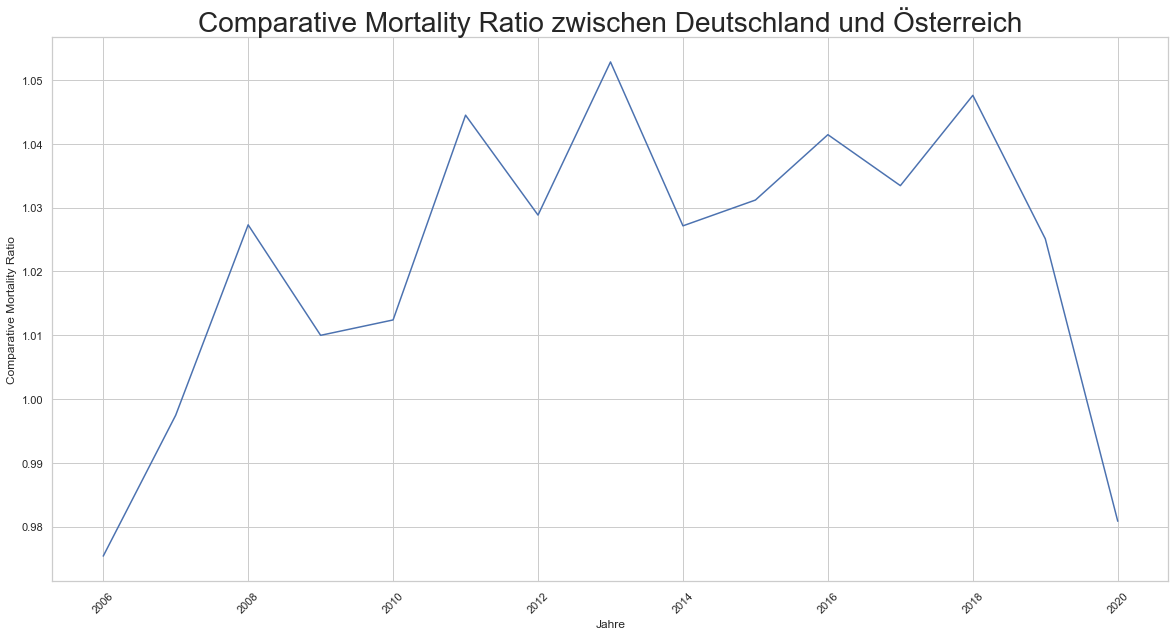

In [97]:
ax = sns.lineplot(x="Jahr",  y='cmr', data=cmr_df_vgl)
ax.set_title("Comparative Mortality Ratio zwischen Deutschland und Österreich", fontsize= 28)
ax.set_ylabel("Comparative Mortality Ratio")
ax.set_xlabel("Jahre")
sns.set(font_scale=2)
plt.gcf().set_size_inches(20, 10)
plt.xticks(rotation=45)

## 4. Berechnung des Erwartungswerts mithilfe von Regressionsanalyse für Deutschland
Die Regressionsanalyse ist ein statistisches Verfahren zur Modellierung von Beziehungen zwischen unterschiedlichen Variablen (abhängige und unabhängige). Sie wird einerseits verwendet, um Zusammenhänge in Daten zu beschreiben und zu analysieren. Andererseits lassen sich mit Regressionsanalysen auch Vorhersagen treffen. Für Prognosen werden die Zusammenhänge in den Daten als Grundlage verwendet.

In [98]:
#Gesamtbevölkerung je Jahr
df_gesamt_bev_de =  df_aufgeteilte_altersgruppen.loc[df_aufgeteilte_altersgruppen.Alter == "Gesamt"][["Jahr", "Anzahl"]]
df_gesamt_bev_de = df_gesamt_bev_de.loc[df_gesamt_bev_de.Jahr >1999].sort_values("Jahr",ascending=False).reset_index(drop= True)


#Todesfälle altersbereinigt und roh
sterberaten_bereinigt_de["Todesfälle_altersbereinigt"] = (sterberaten_bereinigt_de.Sterberate_bereinigt/100000) * df_gesamt_bev_de.Anzahl
sterberaten_bereinigt_de["Todesfälle_rohe"] = (sterberaten_roh_de.Sterberate_Roh/100000) * df_gesamt_bev_de.Anzahl
pd.options.display.float_format = '{:.4f}'.format
sterberaten_bereinigt_de

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2021,1213.4906,1010074.6944,1021430.0000
1,2020,1185.2223,985572.0000,985572.0000
2,2019,1149.6736,956145.7247,939520.0000
3,2018,1197.3936,994066.7671,954874.0000
4,2017,1188.1074,983662.0751,932263.0000
5,2016,1179.4441,973296.7617,910899.0000
6,2015,1224.6695,1006380.5788,925200.0000
7,2014,1173.9001,953177.9543,868356.0000
8,2013,1245.7843,1006188.3459,893825.0000
9,2012,1234.3103,993912.9049,869582.0000


Aufteilung der Daten für die Vorhersage der Erwarteteb Todesfälle für das Jahr 2021

In [99]:
lm_test_df = sterberaten_bereinigt_de.loc[(sterberaten_bereinigt_de["Jahr"] > 1999) & (sterberaten_bereinigt_de["Jahr"] < 2021 )]

#Datensatz aufbereiten damit die 
df_fuer_trendlinien = lm_test_df.copy()
df_fuer_trendlinien = df_fuer_trendlinien.sort_values('Jahr')
df_fuer_trendlinien = df_fuer_trendlinien.reset_index(drop= True)
df_fuer_trendlinien



,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2000,1432.4470,1178324.3406,838797.0000
1,2001,1396.6442,1151397.7906,828541.0000
2,2002,1412.8995,1166160.3282,841687.0000
3,2003,1426.8828,1177630.1910,853946.0000
4,2004,1325.8127,1093806.7469,818271.0000
5,2005,1314.4881,1083637.6495,830227.0000
6,2006,1280.3142,1053889.4323,821627.0000
7,2007,1272.3824,1046125.2868,827155.0000
8,2008,1284.0406,1052943.5226,844439.0000
9,2009,1265.8938,1035529.6727,854544.0000


### Erstellen der Trendlinien 
Im folgenden Abschnitt werden mittel einer einfacher oder multipler Regression die Trendlinen aus unseren zuvor altersbereinigten Daten erstellt. Anhand der Trendlinien kann dann in den folgenden Schritten die Anzahl der Erwarteten Toden vorhergesagt werden. Als Gütemaß wird anschließend noch das Bestimmtheitsmaß ermittelt.

**Linear**

In [100]:
##Erstellen der Trendline
coeff_2021_2 = np.polyfit(df_fuer_trendlinien.Jahr, df_fuer_trendlinien.Todesfälle_altersbereinigt ,1) # 1 = linear, 2 = x^2
m_2021_2 = coeff_2021_2[0]
b_2021_2 = coeff_2021_2[1]

**Quadratisch**

In [101]:
coeff_2021 = np.polyfit(df_fuer_trendlinien.Jahr, df_fuer_trendlinien.Todesfälle_altersbereinigt ,2) 
m_2021 = coeff_2021[0]
b_2021 = coeff_2021[1]


**Polynom 3 Grades**

In [102]:
coeff_2021_polynom_3 = np.polyfit(df_fuer_trendlinien.Jahr, df_fuer_trendlinien.Todesfälle_altersbereinigt ,3) 
b_2021_3 = coeff_2021_polynom_3[1]

**Polynom 4 Grades**

In [103]:
coeff_2021_polynom_4 = np.polyfit(df_fuer_trendlinien.Jahr, df_fuer_trendlinien.Todesfälle_altersbereinigt ,4) 
m_2021_4 = coeff_2021_polynom_4[0]
b_2021_4 = coeff_2021_polynom_4[1]

### Ermitteln des Bestimmtheitsmaß

Das Bestimmtheitsmaß, auch mit ${\displaystyle {\mathit {R}}^{2}}$ bezeichnet wird, ist in der Statistik eine Kennzahl zur Beurteilung der Anpassungsgüte einer Regression – beispielsweise, um zu bewerten, wie gut Messwerte zu einem Modell passen. Das Bestimmtheitsmaß beruht auf der Quadratsummenzerlegung, bei der die totale Quadratsumme in die (durch das Regressionsmodell) erklärte Quadratsumme und in die Residuenquadratsumme zerlegt wird. 

In [104]:
werte_linear = pd.Series(np.polyval(coeff_2021_2, df_fuer_trendlinien.Jahr)).to_numpy()
werte_grad_2 = pd.Series(np.polyval(coeff_2021, df_fuer_trendlinien.Jahr)).to_numpy()
werte_grad_3 = pd.Series(np.polyval(coeff_2021_polynom_3, df_fuer_trendlinien.Jahr)).to_numpy()
werte_grad_4 = pd.Series(np.polyval(coeff_2021_polynom_4, df_fuer_trendlinien.Jahr)).to_numpy()

bestimmtheitsmas_linear = r2_score(df_fuer_trendlinien.Todesfälle_altersbereinigt,werte_linear)
bestimmtheitsmass_grad_2 = r2_score(df_fuer_trendlinien.Todesfälle_altersbereinigt,werte_grad_2)
bestimmtheitsmass_grad_3 = r2_score(df_fuer_trendlinien.Todesfälle_altersbereinigt,werte_grad_3)
bestimmtheitsmass_grad_4 = r2_score(df_fuer_trendlinien.Todesfälle_altersbereinigt,werte_grad_4)

##### Darstellung der Trendlinien für eine einfache oder multiple Regression Deutschland

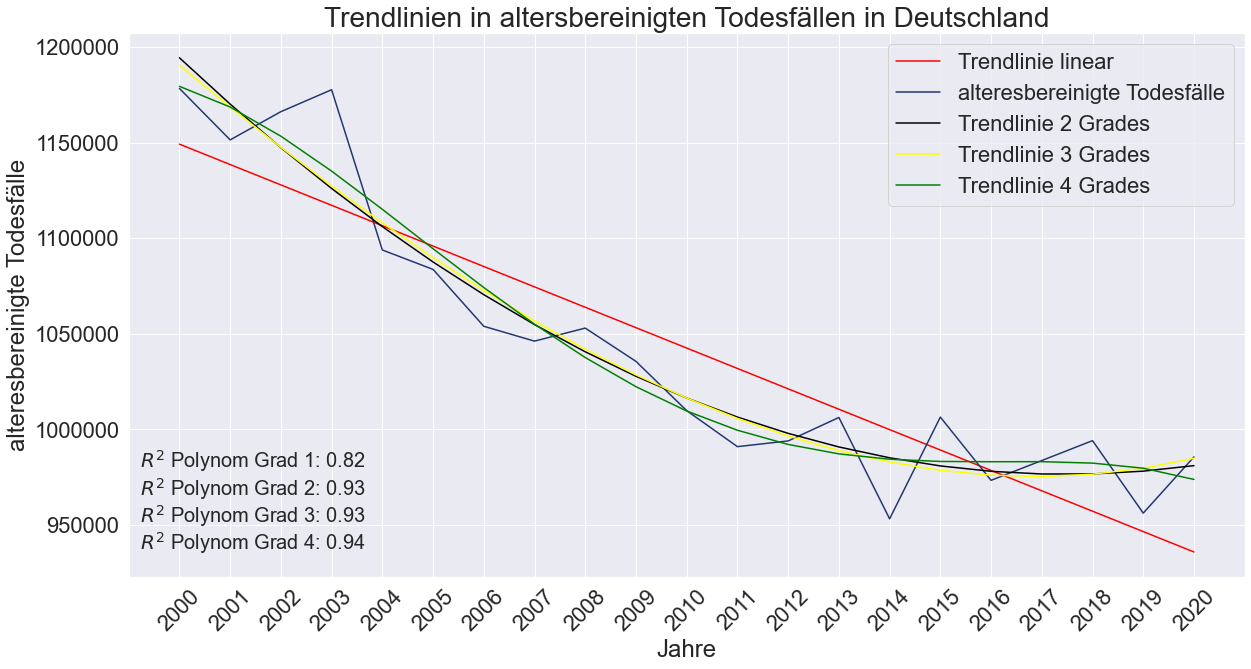

In [105]:

df_fuer_trendlinien['predicted'] = pd.Series(np.polyval(coeff_2021_2, df_fuer_trendlinien.Jahr))
df_fuer_trendlinien['predicted_2'] = pd.Series(np.polyval(coeff_2021, df_fuer_trendlinien.Jahr))
df_fuer_trendlinien['predicted_3'] = pd.Series(np.polyval(coeff_2021_polynom_3, df_fuer_trendlinien.Jahr))
df_fuer_trendlinien['predicted_4'] = pd.Series(np.polyval(coeff_2021_polynom_4, df_fuer_trendlinien.Jahr))
sns.set(font_scale=2)


ax = sns.lineplot(x="Jahr",  y='predicted', data=df_fuer_trendlinien, color ="red")
plot_linear = sns.lineplot(ax=ax, x="Jahr",  y='Todesfälle_altersbereinigt', data=df_fuer_trendlinien, color=hs_blau)
plot_linear2 = sns.lineplot(ax=plot_linear, x="Jahr",  y='predicted_2', data=df_fuer_trendlinien, color="black")
plot_linear3 = sns.lineplot(ax=plot_linear, x="Jahr",  y='predicted_3', data=df_fuer_trendlinien, color="yellow")
plot_linear4 = sns.lineplot(ax=plot_linear, x="Jahr",  y='predicted_4', data=df_fuer_trendlinien, color="green")

# plot_linear2.fill_between(x=df.Jahr,y1=df.predicted, y2=df.Todesfälle_altersbereinigt, where=(df.predicted > df.Todesfälle_altersbereinigt),color= "#22376f", alpha=0.9, interpolate=True)
# plot_linear2.fill_between(x=df.Jahr,y1=df.predicted, y2=df.Todesfälle_altersbereinigt, where=(df.predicted <= df.Todesfälle_altersbereinigt),color= "#df2020", alpha=0.9, interpolate=True)

plt.legend(labels=["Trendlinie linear", 'alteresbereinigte Todesfälle', 'Trendlinie 2 Grades','Trendlinie 3 Grades', 'Trendlinie 4 Grades'])
sns.set_theme(style="whitegrid")

plot_linear.axes.annotate(f"$R^2$ Polynom Grad 1: {bestimmtheitsmas_linear:.2f}", xy=(0.01,0.2), xycoords='axes fraction', fontsize = 20)
plot_linear.axes.annotate(f"$R^2$ Polynom Grad 2: {bestimmtheitsmass_grad_2:.2f}", xy=(0.01,0.15), xycoords='axes fraction', fontsize = 20)
plot_linear.axes.annotate(f"$R^2$ Polynom Grad 3: {bestimmtheitsmass_grad_3:.2f}", xy=(0.01,0.1), xycoords='axes fraction', fontsize = 20)
plot_linear.axes.annotate(f"$R^2$ Polynom Grad 4: {bestimmtheitsmass_grad_4:.2f}", xy=(0.01,0.05), xycoords='axes fraction', fontsize = 20)

plot_linear.set_title("Trendlinien in altersbereinigten Todesfällen in Deutschland", fontsize= 28)
plot_linear.ticklabel_format(axis="y", style="plain")
plot_linear.set_ylabel("alteresbereinigte Todesfälle")
plot_linear.set_xlabel("Jahre")
plt.xticks(range(2000, 2021, 1))
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)



Mithilfe der polyval Funktion aus der Numpy Bibliothek, werden die Todesfälle für das Jahr 2021 vorhergesagt.

In [106]:
pred_totesfaelle = np.polyval(coeff_2021, 2021)  # adding a row
pred_totesfaelle

985295.581920147

### Auswertung über Unter- oder Übersterblichkeit

Für die Auswertung ob es in einem Jahr eine Unter- oder Übersterblichkeit aufgetreten ist, wird die Differenz zwischen unseren altersbereingten Todesfällen und den erwarteten Toten von unserem Modell geblidet.

##### Erwartungswert Tote 2021
Mithilfe der polyval Funktion aus der Numpy Bibliothek, werden die Todesfälle für das Jahr 2021 vorhergesagt.

In [107]:
pred_totesfaelle = np.polyval(coeff_2021, 2021)  # adding a row
pred_totesfaelle

985295.581920147

#### Erwartungswert Tote von 2000-2022
Für die Vorhersage der jeweiligen Jahre, werden jeweilig die 10 Jahre als Trainingsdaten verwendet um anschließed das jeweilige Jahr vorherzusagen. 
Da wir die Daten die Jahre von 2000-2021 abdecken, könnne wir mit diesem Verfahren nur die Jahre ab 2010 zuverlässig vorhersagen.

In [108]:
#Erwarteten Todesfälle
erwartungswerte = []

#bestimmen der erwarteten Toten von 2000 - 2010 anhand polyfit insgesamt
for idx2 in range(2000,2010,1):    
    erwartungswerte.append([idx2,np.polyval(coeff_2021, idx2)])

#bestimmen der erwarteten Toten von 2010 - 2021 anhand polyfit der letzten 10 jahre
for idx in range(1999,2010,1):
    
    temp_df = sterberaten_bereinigt_de.loc[(sterberaten_bereinigt_de["Jahr"] > idx) & (sterberaten_bereinigt_de["Jahr"] < idx+11)]
    coeff_temp = np.polyfit(temp_df.Jahr, temp_df.Todesfälle_altersbereinigt ,2) # 1 = linear, 2 = ploynom 2 Grades
    erwartungswerte.append([idx+12,np.polyval(coeff_2021, idx+12)])

df_erwartungswerte = pd.DataFrame(erwartungswerte, columns=["Jahr", "Erwartete Todesfälle"])
df_erwartungswerte

,Jahr,Erwartete Todesfälle
0,2000,1194338.5375
1,2001,1170122.4251
2,2002,1147332.4812
3,2003,1125968.7060
4,2004,1106031.0993
5,2005,1087519.6613
6,2006,1070434.3919
7,2007,1054775.2910
8,2008,1040542.3588
9,2009,1027735.5951


**Berechnung der Unter-Übersterblichkeit**

In [109]:
df_2011_bis_2020 = sterberaten_bereinigt_de.loc[sterberaten_bereinigt_de.Jahr > 2000].sort_values("Jahr").reset_index(drop=True)
df_2011_bis_2020["Delta_erwartet_altersbereinigt"] = df_2011_bis_2020["Todesfälle_altersbereinigt"] - df_erwartungswerte["Erwartete Todesfälle"]
df_2011_bis_2020

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe,Delta_erwartet_altersbereinigt
0,2001,1396.6442,1151397.7906,828541.0000,-42940.7470
1,2002,1412.8995,1166160.3282,841687.0000,-3962.0969
2,2003,1426.8828,1177630.1910,853946.0000,30297.7098
3,2004,1325.8127,1093806.7469,818271.0000,-32161.9591
4,2005,1314.4881,1083637.6495,830227.0000,-22393.4499
5,2006,1280.3142,1053889.4323,821627.0000,-33630.2290
6,2007,1272.3824,1046125.2868,827155.0000,-24309.1051
7,2008,1284.0406,1052943.5226,844439.0000,-1831.7684
8,2009,1265.8938,1035529.6727,854544.0000,-5012.6860
9,2010,1235.1500,1009754.9138,858768.0000,-17980.6813


### Mean und Standardabweichung

In [110]:
# mean sollte ~ 0 sein
mean_delta = df_2011_bis_2020.Delta_erwartet_altersbereinigt.mean()

#Standardabweichung
std_delta = df_2011_bis_2020.Delta_erwartet_altersbereinigt.std()


print(std_delta)

21385.623350406415


### Barplot über Todesfälle - Erwartete Todesfälle (Altersbereinigt)

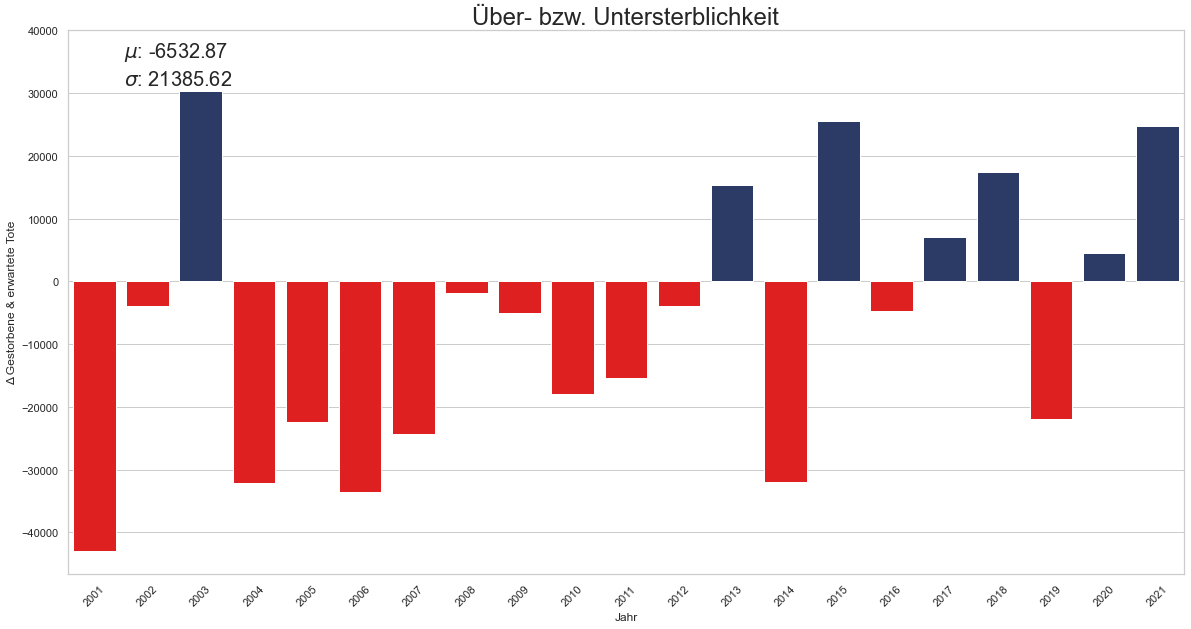

In [111]:
clrs = ['red' if y<=0 else hs_blau for y in df_2011_bis_2020.Delta_erwartet_altersbereinigt]
barplot_todesfaelle = sns.barplot(data = df_2011_bis_2020, x= "Jahr", y = "Delta_erwartet_altersbereinigt", palette=clrs)
sns.set(font_scale=2)


barplot_todesfaelle.axes.annotate(f"$\mu$: {mean_delta:.2f}", xy=(0.05,0.95), xycoords='axes fraction', fontsize = 20)
barplot_todesfaelle.axes.annotate(f"$\sigma$: {std_delta:.2f}", xy=(0.05,0.9), xycoords='axes fraction', fontsize = 20)

barplot_todesfaelle.set_ylabel("Δ Gestorbene & erwartete Tote")
barplot_todesfaelle.set_xlabel("Jahr")
barplot_todesfaelle.set_title("Über- bzw. Untersterblichkeit")
y1 = df_2011_bis_2020.Delta_erwartet_altersbereinigt


plt.yticks(range(-40000, 50000, 10000))
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)


### Angaben der Normalverteilung 
Eine der Voraussetzungen für eine einfache oder multiple Regression ist die Normalverteilung. In der Medizin werden Histogramme welche eine "ungefähren" Verlauf einer normal Verteilung aufweisen, als normalverteilt betrachtet.

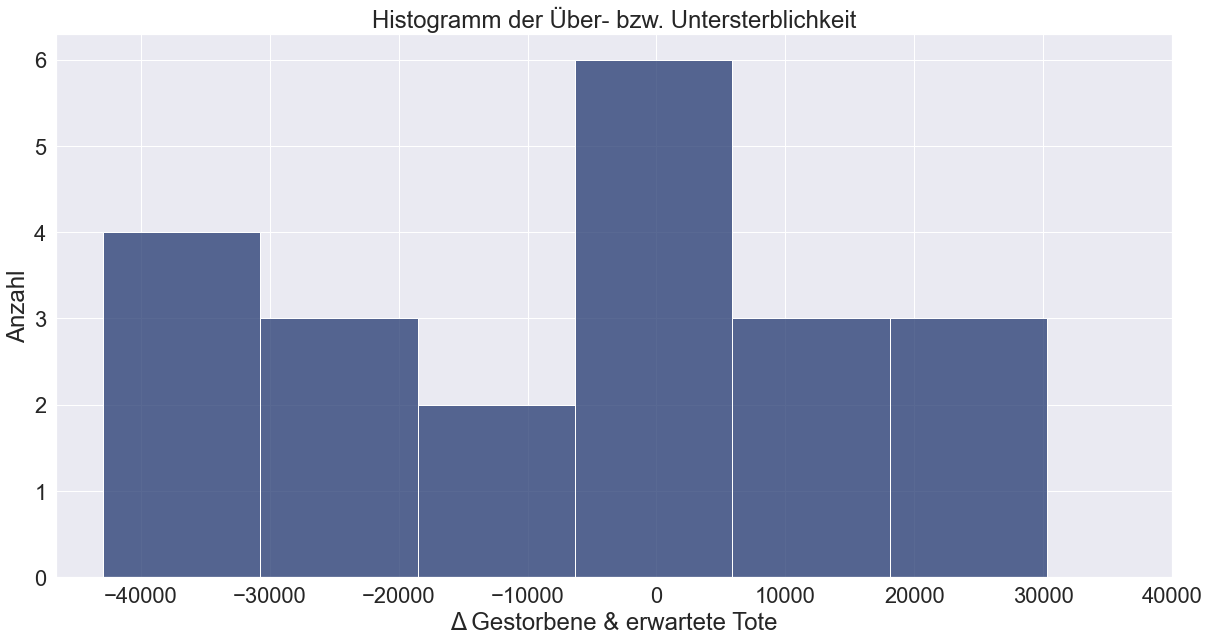

In [112]:
barplot_histo = sns.histplot(data=df_2011_bis_2020, x= "Delta_erwartet_altersbereinigt", color=hs_blau)
barplot_histo.set_ylabel("Anzahl")
barplot_histo.set_xlabel("Δ Gestorbene & erwartete Tote")
barplot_histo.set_title("Histogramm der Über- bzw. Untersterblichkeit")
plt.xticks(range(-40000, 50000, 10000))
plt.gcf().set_size_inches(20, 10)

### Ranking Über- bzw. Untersterblichkeit Deutschland

Für eine einfacherer Betachtung werden die Daten nach Ihrem max. und min. Wert in Unter/Übersterblichkeit sortiert und anschließend in einem Ranking dargstellt.

In [113]:
df_2011_bis_2020_sorted  = df_2011_bis_2020.sort_values(by=["Delta_erwartet_altersbereinigt"])
df_2011_bis_2020_sorted = df_2011_bis_2020_sorted.reset_index(drop= True)
years_sorted_by_delta = df_2011_bis_2020_sorted["Jahr"].to_list()

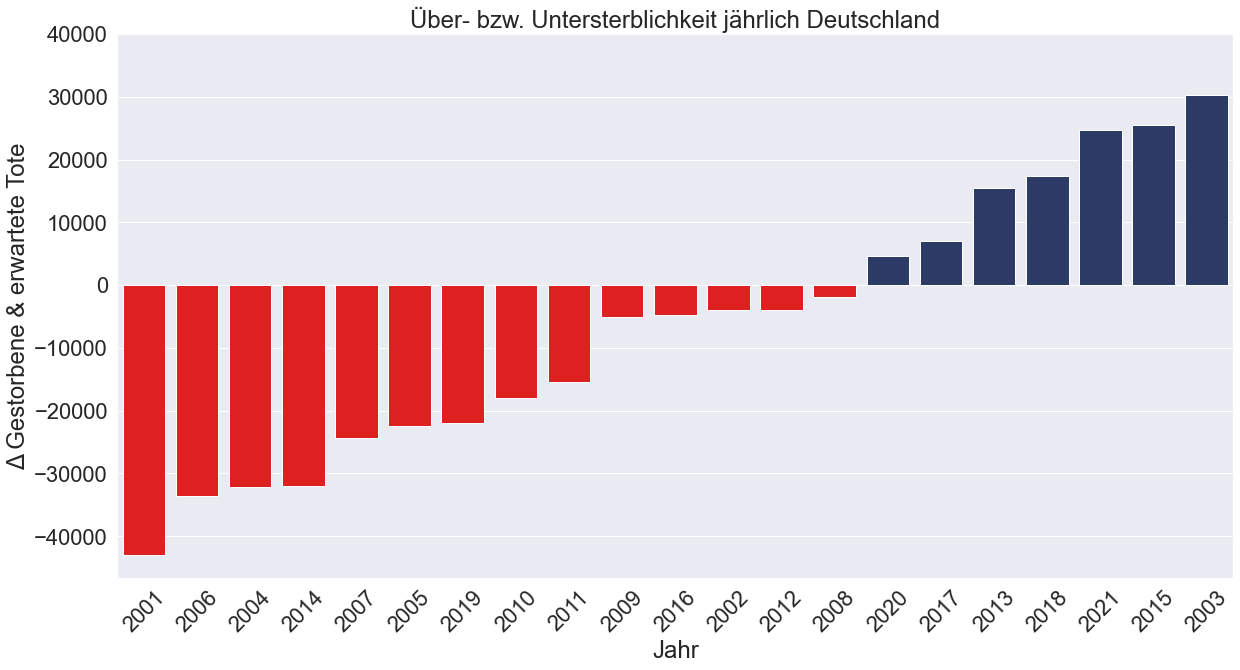

In [114]:
clrs = ['red' if y<=0 else hs_blau for y in df_2011_bis_2020_sorted.Delta_erwartet_altersbereinigt]


barplot_todesfaelle_sorted = sns.barplot(data = df_2011_bis_2020_sorted, x= df_2011_bis_2020_sorted.Jahr, y = df_2011_bis_2020_sorted.Delta_erwartet_altersbereinigt, order = years_sorted_by_delta, palette=clrs)
sns.set(font_scale=2)

barplot_todesfaelle_sorted.set_ylabel("Δ Gestorbene & erwartete Tote")
barplot_todesfaelle_sorted.set_xlabel("Jahr")
barplot_todesfaelle_sorted.set_title("Über- bzw. Untersterblichkeit jährlich Deutschland")

plt.yticks(range(-40000, 50000, 10000))
plt.xticks(rotation=45)
plt.gcf().set_size_inches(20, 10)

## 5. Saisonale Bereinigung der Daten für Deutschland 


In [115]:
#Gesamtbevölkerung je Jahr
df_gesamt_bev_saisonal =  df_aufgeteilte_altersgruppen.loc[df_aufgeteilte_altersgruppen.Alter == "Gesamt"][["Jahr", "Anzahl"]]
df_gesamt_bev_saisonal = df_gesamt_bev_saisonal.loc[df_gesamt_bev_saisonal.Jahr >1999].sort_values("Jahr",ascending=False).reset_index(drop= True)
df_gesamt_bev_saisonal


sterberaten_bereinigt_de_saisonal["Todesfälle_altersbereinigt"] = (sterberaten_bereinigt_de_saisonal.Sterberate_bereinigt/100000) * df_gesamt_bev_saisonal.Anzahl
sterberaten_bereinigt_de_saisonal["Todesfälle_rohe"] = (sterberaten_roh_de_saisonal.Sterberate_Roh/100000) * df_gesamt_bev_saisonal.Anzahl
pd.options.display.float_format = '{:.4f}'.format

sterberaten_bereinigt_de_saisonal

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2021,1117.4642,930145.0711,941412.0000
1,2020,1215.8952,1011078.0000,1011078.0000
2,2019,1156.6015,961907.4266,944335.0000
3,2018,1170.6376,971854.1553,932898.0000
4,2017,1206.2081,998648.0541,945507.0000
5,2016,1216.6074,1003964.5580,937991.0000
6,2015,1190.3150,978149.4521,899181.0000
7,2014,1251.2526,1015986.3303,923446.0000
8,2013,1187.3506,958992.9502,853426.0000
9,2012,1277.4700,1028666.7247,899066.0000


In [116]:
lm_test_df_saisonal = sterberaten_bereinigt_de_saisonal.loc[(sterberaten_bereinigt_de_saisonal["Jahr"] > 1999) & (sterberaten_bereinigt_de_saisonal["Jahr"] < 2021 )]
lm_test_df_saisonal

#Datensatz aufbereiten
df_de_saisonal = lm_test_df_saisonal.copy()
df_de_saisonal = df_de_saisonal.sort_values('Jahr')
df_de_saisonal = df_de_saisonal.reset_index(drop= True)
df_de_saisonal

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2001,1412.9683,1164855.4083,835504.0000
1,2002,1439.1095,1187793.1623,856527.0000
2,2003,1380.9244,1139700.0087,830164.0000
3,2004,1354.6302,1117581.4412,833867.0000
4,2005,1295.0603,1067621.7198,815882.0000
5,2006,1282.8054,1055940.0939,822482.0000
6,2007,1296.5261,1065975.7179,841883.0000
7,2008,1303.5501,1068941.8259,857159.0000
8,2009,1246.5682,1019720.9296,841183.0000
9,2010,1233.2530,1008204.0862,856648.0000


#### Erzeugen der Trendline mit Saisonalen Daten 

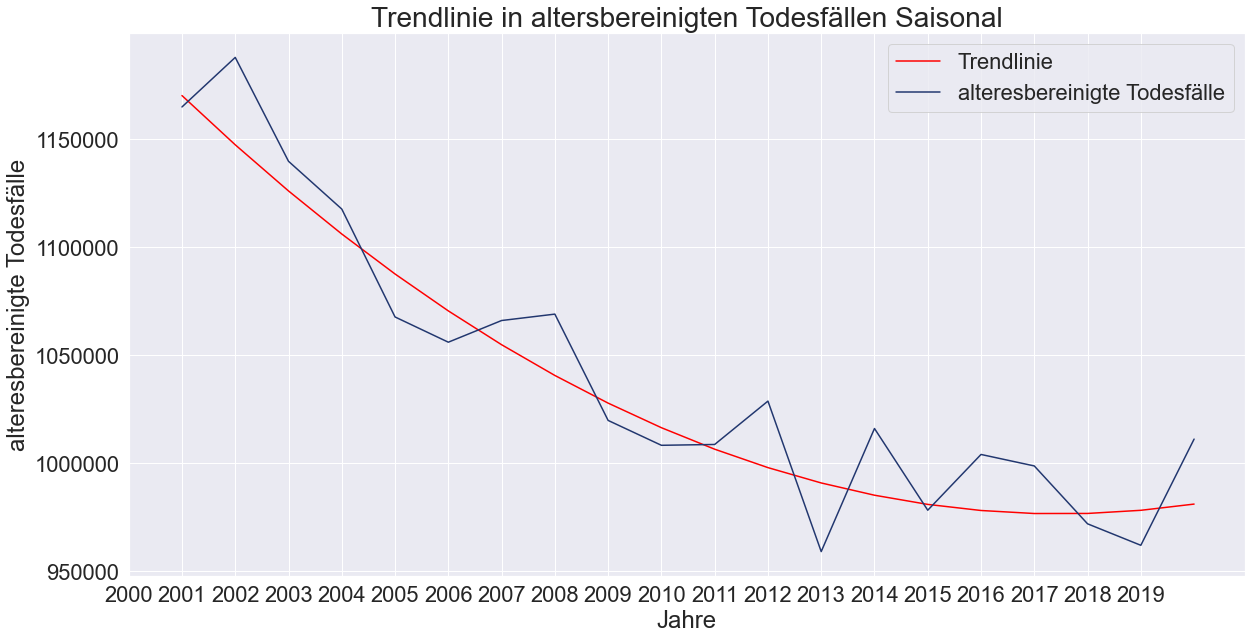

In [117]:
##Erstellen der Trendline
coeff_2021_saisonal = np.polyfit(df_de_saisonal.Jahr, df_de_saisonal.Todesfälle_altersbereinigt ,2) # 1 = linear, 2 = x^2
m_2021_saisonal = coeff_2021_saisonal[0]
b_2021_saisonal = coeff_2021_saisonal[1]

df_de_saisonal['predicted'] = pd.Series(np.polyval(coeff_2021, df_de_saisonal.Jahr))
sns.set(font_scale=2)


ax = sns.lineplot(x="Jahr",  y='predicted', data=df_de_saisonal, color ="red")
plot_linear = sns.lineplot(ax=ax, x="Jahr",  y='Todesfälle_altersbereinigt', data=df_de_saisonal, color=hs_blau)
plt.legend(labels=['Trendlinie', 'alteresbereinigte Todesfälle'])
sns.set_theme(style="whitegrid")

plot_linear.set_title("Trendlinie in altersbereinigten Todesfällen Saisonal", fontsize= 28)
plot_linear.ticklabel_format(axis="y", style="plain")
plot_linear.set_ylabel("alteresbereinigte Todesfälle")
plot_linear.set_xlabel("Jahre")
plt.xticks(range(2000, 2020, 1))

plt.gcf().set_size_inches(20, 10)

#### Erstellen der Erwartungswerte

In [118]:
pred_totesfaelle_saisonal = np.polyval(coeff_2021_saisonal, 2020)  # adding a row
pred_totesfaelle_saisonal


#Erwarteten Todesfälle von 2000-2021
erwartungswerte_saisonal = []

#bestimmen der erwarteten Toten von 2000 - 2010 anhand polyfit insgesamt
for idx2 in range(2000,2010,1):    
    erwartungswerte_saisonal.append([idx2,np.polyval(coeff_2021_saisonal, idx2)])

#bestimmen der erwarteten Toten von 2010 - 2021 anhand polyfit der letzten 10 jahre
for idx in range(1999,2010,1):
    
    temp_df = sterberaten_bereinigt_de_saisonal.loc[(sterberaten_bereinigt_de_saisonal["Jahr"] > idx) & (sterberaten_bereinigt_de_saisonal["Jahr"] < idx+11)]
    coeff_temp = np.polyfit(temp_df.Jahr, temp_df.Todesfälle_altersbereinigt ,2) # 1 = linear
    erwartungswerte_saisonal.append([idx+12,np.polyval(coeff_2021_saisonal, idx+12)])

df_erwartungswerte_saisonal = pd.DataFrame(erwartungswerte_saisonal, columns=["Jahr", "Erwartete Todesfälle"])
df_erwartungswerte_saisonal

,Jahr,Erwartete Todesfälle
0,2000,1207795.9924
1,2001,1181667.3840
2,2002,1157166.7913
3,2003,1134294.2142
4,2004,1113049.6529
5,2005,1093433.1072
6,2006,1075444.5773
7,2007,1059084.0630
8,2008,1044351.5644
9,2009,1031247.0815


#### Unter- und Übersterblichkeit ermitteln 

In [119]:
df_2011_bis_2020_saisonal = sterberaten_bereinigt_de_saisonal.loc[sterberaten_bereinigt_de_saisonal.Jahr > 2000].sort_values("Jahr").reset_index(drop=True)
df_2011_bis_2020_saisonal["Delta_erwartet_altersbereinigt"] = df_2011_bis_2020_saisonal["Todesfälle_altersbereinigt"] - df_erwartungswerte_saisonal["Erwartete Todesfälle"]
df_2011_bis_2020_saisonal

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe,Delta_erwartet_altersbereinigt
0,2001,1412.9683,1164855.4083,835504.0000,-42940.5841
1,2002,1439.1095,1187793.1623,856527.0000,6125.7783
2,2003,1380.9244,1139700.0087,830164.0000,-17466.7826
3,2004,1354.6302,1117581.4412,833867.0000,-16712.7731
4,2005,1295.0603,1067621.7198,815882.0000,-45427.9331
5,2006,1282.8054,1055940.0939,822482.0000,-37493.0133
6,2007,1296.5261,1065975.7179,841883.0000,-9468.8594
7,2008,1303.5501,1068941.8259,857159.0000,9857.7629
8,2009,1246.5682,1019720.9296,841183.0000,-24630.6348
9,2010,1233.2530,1008204.0862,856648.0000,-23042.9953


### Mean und Standardabweichung für Saisonale Bereinigung

In [120]:
# mean sollte ~ 0 sein
mean_delta_saisonal = df_2011_bis_2020_saisonal.Delta_erwartet_altersbereinigt.mean()

#Standardabweichung
std_delta_saisonal = df_2011_bis_2020_saisonal.Delta_erwartet_altersbereinigt.std()
print(std_delta_saisonal)

26142.370166503973


#### Visualisierung der Unter - Übersterblichkeit Saisonal 

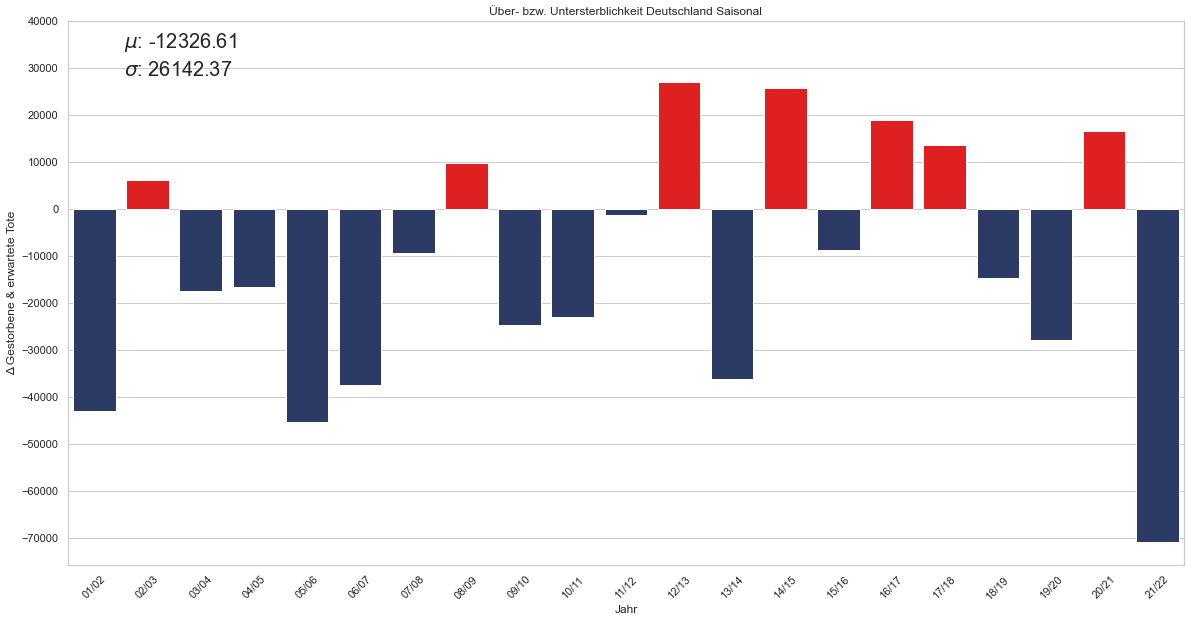

In [121]:
clrs = [hs_blau if y<=0 else 'red' for y in df_2011_bis_2020_saisonal.Delta_erwartet_altersbereinigt]
labels = ["01/02", "02/03", "03/04", "04/05", "05/06", "06/07", "07/08", "08/09", "09/10", "10/11", "11/12", "12/13", "13/14", "14/15", "15/16", "16/17", "17/18", "18/19", "19/20","20/21", "21/22"]

barplot_todesfaelle_saisonal = sns.barplot(data = df_2011_bis_2020_saisonal, x= "Jahr", y = "Delta_erwartet_altersbereinigt", palette=clrs)

barplot_todesfaelle_saisonal.axes.annotate(f"$\mu$: {mean_delta_saisonal:.2f}", xy=(0.05,0.95), xycoords='axes fraction', fontsize = 20)
barplot_todesfaelle_saisonal.axes.annotate(f"$\sigma$: {std_delta_saisonal:.2f}", xy=(0.05,0.9), xycoords='axes fraction', fontsize = 20)

barplot_todesfaelle_saisonal.set_ylabel("Δ Gestorbene & erwartete Tote")
barplot_todesfaelle_saisonal.set_xlabel("Jahr")
barplot_todesfaelle_saisonal.set_title("Über- bzw. Untersterblichkeit Deutschland Saisonal")


plt.yticks(range(-70000, 50000, 10000))
barplot_todesfaelle_saisonal.set_xticklabels(labels,rotation=45)
sns.set(font_scale=2)
plt.gcf().set_size_inches(20, 10)

### Ranking Über- bzw. Untersterblichkeit Saisonal

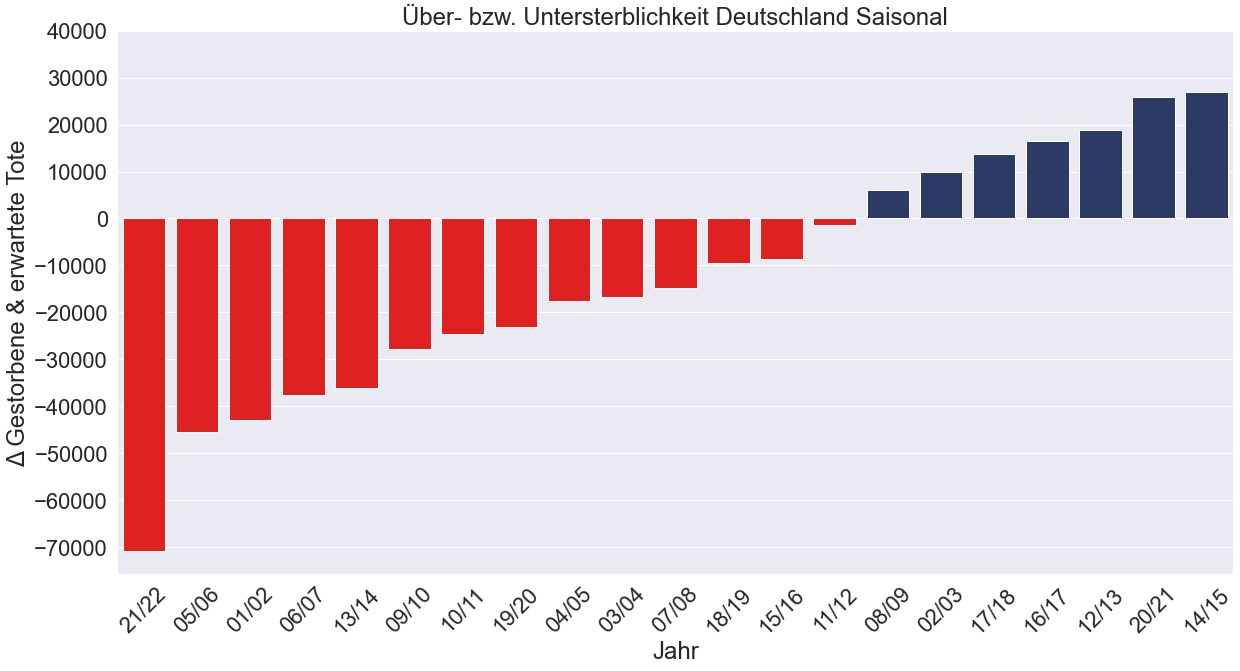

In [122]:
df_2011_bis_2020_sorted_saisonal  = df_2011_bis_2020_saisonal.sort_values(by=["Delta_erwartet_altersbereinigt"])
df_2011_bis_2020_sorted_saisonal = df_2011_bis_2020_sorted_saisonal.reset_index(drop= True)
years_sorted_by_delta_saisonal = df_2011_bis_2020_sorted_saisonal["Jahr"].to_list()

clrs = ["red" if y<=0 else hs_blau for y in df_2011_bis_2020_sorted_saisonal.Delta_erwartet_altersbereinigt]
labels = ["21/22","05/06", "01/02", "06/07", "13/14", "09/10", "10/11", "19/20", "04/05", "03/04", "07/08", "18/19", "15/16", "11/12", "08/09", "02/03", "17/18", "16/17", "12/13", "20/21", "14/15"]

barplot_todesfaelle_sorted_saisonal = sns.barplot(data = df_2011_bis_2020_sorted_saisonal, x= df_2011_bis_2020_sorted_saisonal.Jahr, y = df_2011_bis_2020_sorted_saisonal.Delta_erwartet_altersbereinigt, order = years_sorted_by_delta_saisonal, palette=clrs)
sns.set(font_scale=2)

barplot_todesfaelle_sorted_saisonal.set_ylabel("Δ Gestorbene & erwartete Tote")
barplot_todesfaelle_sorted_saisonal.set_xlabel("Jahr")
barplot_todesfaelle_sorted_saisonal.set_title("Über- bzw. Untersterblichkeit Deutschland Saisonal")

barplot_todesfaelle_sorted_saisonal.set_xticklabels(labels,rotation=45)
plt.yticks(range(-70000, 50000, 10000))
plt.gcf().set_size_inches(20, 10)

### Ranking Über- bzw. Untersterblichkeit Saisonal bereinigt

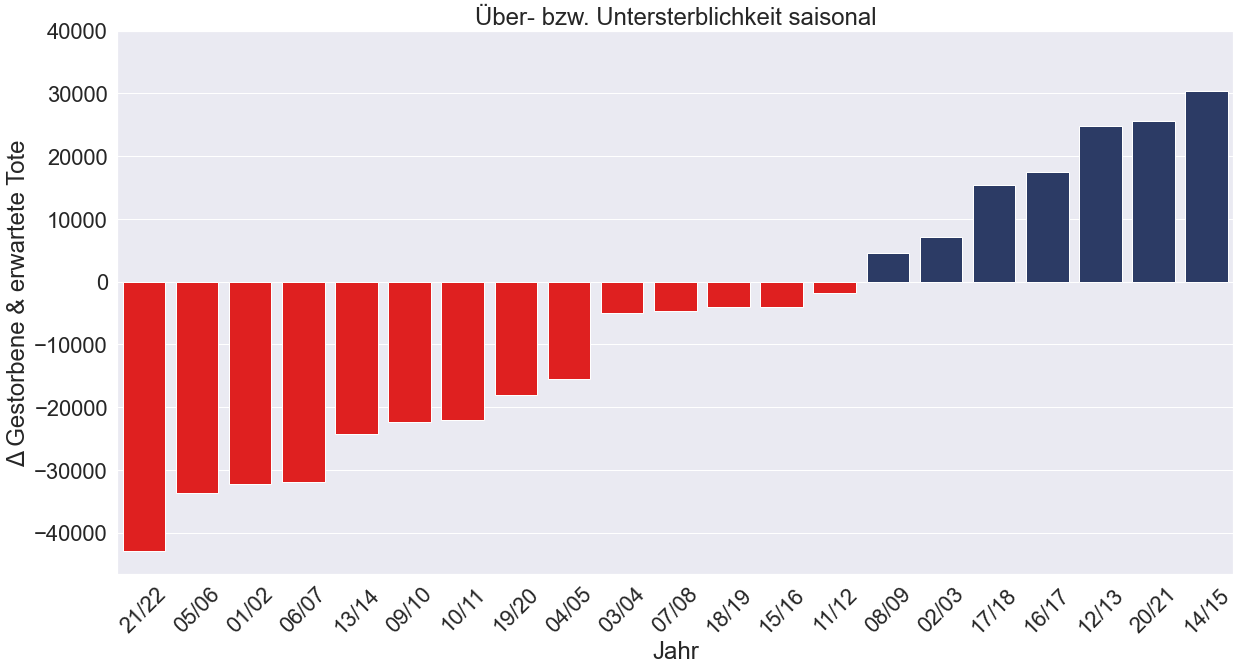

In [123]:
#Sortieren der Daten
df_2011_bis_2020_sorted  = df_2011_bis_2020.sort_values(by=["Delta_erwartet_altersbereinigt"])
df_2011_bis_2020_sorted = df_2011_bis_2020_sorted.reset_index(drop= True)
years_sorted_by_delta = df_2011_bis_2020_sorted["Jahr"].to_list()

#Plot konfig
clrs = ["red" if y<=0 else hs_blau for y in df_2011_bis_2020_sorted.Delta_erwartet_altersbereinigt]
labels = ["21/22","05/06", "01/02", "06/07", "13/14", "09/10", "10/11", "19/20", "04/05", "03/04", "07/08", "18/19", "15/16", "11/12", "08/09", "02/03", "17/18", "16/17", "12/13", "20/21", "14/15"]

barplot_todesfaelle_sorted = sns.barplot(data = df_2011_bis_2020_sorted, x= df_2011_bis_2020_sorted.Jahr, y = df_2011_bis_2020_sorted.Delta_erwartet_altersbereinigt, order = years_sorted_by_delta, palette=clrs)
sns.set(font_scale=2)

barplot_todesfaelle_sorted.set_ylabel("Δ Gestorbene & erwartete Tote")
barplot_todesfaelle_sorted.set_xlabel("Jahr")
barplot_todesfaelle_sorted.set_title("Über- bzw. Untersterblichkeit saisonal")

barplot_todesfaelle_sorted.set_xticklabels(labels,rotation=45)
plt.yticks(range(-40000, 50000, 10000))
plt.gcf().set_size_inches(20, 10)

## 6. Berechnung des Erwartungswerts mithilfe von Regressionsanalyse für Österreich

#### Erstellung der Trendlinie ähnlich dem Vorbild von Deutschland

In [124]:
df_gesamt_bev_at =  bevölkerung_österreich.loc[bevölkerung_österreich.Altersgruppen == "Gesamt"][["Jahr", "Insgesamt"]]
df_gesamt_bev_at = df_gesamt_bev_at.loc[df_gesamt_bev_at.Jahr >2005].sort_values("Jahr",ascending=False).reset_index(drop= True)
df_gesamt_bev_at

sterberaten_bereinigt_at["Todesfälle_altersbereinigt"] = (sterberaten_bereinigt_at.Sterberate_bereinigt/100000) * df_gesamt_bev_at.Insgesamt
sterberaten_bereinigt_at["Todesfälle_rohe"] = (sterberaten_roh_at.Sterberate_Roh/100000) * df_gesamt_bev_at.Insgesamt
pd.options.display.float_format = '{:.10f}'.format
sterberaten_bereinigt_at


lm_test_df_at = sterberaten_bereinigt_at.loc[(sterberaten_bereinigt_at["Jahr"] > 2005) & (sterberaten_bereinigt_at["Jahr"] < 2020 )]
sterberaten_bereinigt_at

# #Datensatz aufbereiten
trainings_df_at = lm_test_df_at.copy()
trainings_df_at = trainings_df_at.sort_values('Jahr')
trainings_df_at = trainings_df_at.reset_index(drop= True)
trainings_df_at

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2006,1312.6493347203,108726.5343709897,74553.1959568215
1,2007,1275.6344704605,105979.5714860639,74850.2809042007
2,2008,1249.9217302637,104181.0137151292,75327.1375598836
3,2009,1253.3908793546,104678.7316382562,77535.4834285003
4,2010,1220.0354619490,102179.9707963849,77416.4180193047
5,2011,1181.0620663644,99305.1276250232,76779.9515279940
6,2012,1199.7291705836,101399.4298768853,79849.2256426852
7,2013,1183.2664446039,100669.7769167050,80052.2239407657
8,2014,1142.8835228494,98115.7047028158,78961.5100041303
9,2015,1187.6343731146,103329.7842188711,84191.0841611215


**Linear**

In [125]:
coeff_2021_linear_at = np.polyfit(trainings_df_at.Jahr, trainings_df_at.Todesfälle_altersbereinigt ,1) # 1 = linear, 2 = x^2
m_2021_2_at = coeff_2021_linear_at[0]
b_2021_2_at = coeff_2021_linear_at[1]

**Polynom 2 Grades**

In [126]:
coeff_2021_quadratisch_at = np.polyfit(trainings_df_at.Jahr, trainings_df_at.Todesfälle_altersbereinigt ,2) # 1 = linear, 2 = x^2
m_2021_at = coeff_2021_quadratisch_at[0]
b_2021_at = coeff_2021_quadratisch_at[1]

**Polynom 3 Grades**

In [127]:
coeff_2021_polynom_3_at = np.polyfit(trainings_df_at.Jahr, trainings_df_at.Todesfälle_altersbereinigt ,3) # 1 = linear, 2 = x^2
m_2021_3_at = coeff_2021_polynom_3_at[0]
b_2021_3_at = coeff_2021_polynom_3_at[1]

**Polynom 4 Grades**

In [128]:
coeff_2021_polynom_4_at = np.polyfit(trainings_df_at.Jahr, trainings_df_at.Todesfälle_altersbereinigt ,4) # 1 = linear, 2 = x^2
m_2021__at = coeff_2021_polynom_4_at[0]
b_2021_4_at = coeff_2021_polynom_4_at[1]

**Ermitteln des Bestimmtheitsmaß (Determinationskoeffizient)**

In [129]:
werte_linear_at = pd.Series(np.polyval(coeff_2021_linear_at, trainings_df_at.Jahr)).to_numpy()
werte_grad_2_at = pd.Series(np.polyval(coeff_2021_quadratisch_at, trainings_df_at.Jahr)).to_numpy()
werte_grad_3_at = pd.Series(np.polyval(coeff_2021_polynom_3_at, trainings_df_at.Jahr)).to_numpy()
werte_grad_4_at = pd.Series(np.polyval(coeff_2021_polynom_4_at, trainings_df_at.Jahr)).to_numpy()

bestimmtheitsmas_linear_at = r2_score(trainings_df_at.Todesfälle_altersbereinigt,werte_linear_at)
bestimmtheitsmass_grad_2_at = r2_score(trainings_df_at.Todesfälle_altersbereinigt,werte_grad_2_at)
bestimmtheitsmass_grad_3_at = r2_score(trainings_df_at.Todesfälle_altersbereinigt,werte_grad_3_at)
bestimmtheitsmass_grad_4_at = r2_score(trainings_df_at.Todesfälle_altersbereinigt,werte_grad_4_at)

##### Darstellung der Trendlinien für eine einfache oder multiple Regression Österreich

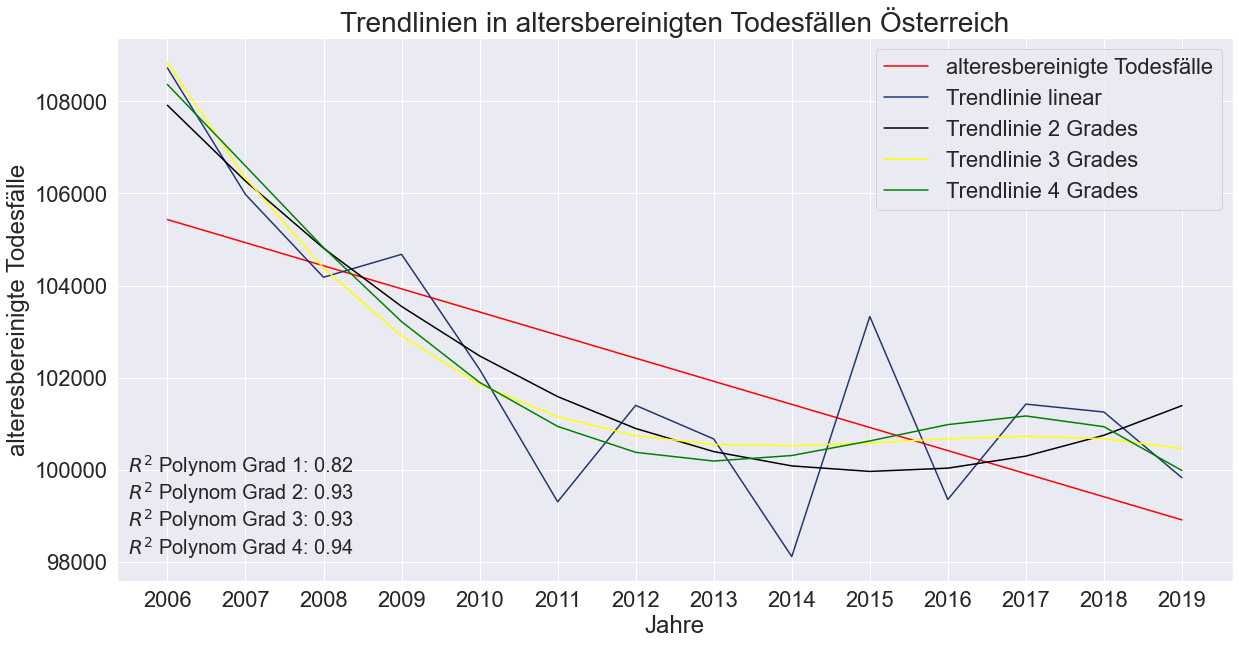

In [130]:
trainings_df_at['predicted'] = pd.Series(np.polyval(coeff_2021_linear_at, trainings_df_at.Jahr))
trainings_df_at['predicted_2'] = pd.Series(np.polyval(coeff_2021_quadratisch_at, trainings_df_at.Jahr))
trainings_df_at['predicted_3'] = pd.Series(np.polyval(coeff_2021_polynom_3_at, trainings_df_at.Jahr))
trainings_df_at['predicted_4'] = pd.Series(np.polyval(coeff_2021_polynom_4_at, trainings_df_at.Jahr))
sns.set(font_scale=2)


ax = sns.lineplot(x="Jahr",  y='predicted', data=trainings_df_at, color ="red")
plot_linear = sns.lineplot(ax=ax, x="Jahr",  y='Todesfälle_altersbereinigt', data=trainings_df_at, color=hs_blau)
plot_linear2 = sns.lineplot(ax=plot_linear, x="Jahr",  y='predicted_2', data=trainings_df_at, color="black")
plot_linear3 = sns.lineplot(ax=plot_linear, x="Jahr",  y='predicted_3', data=trainings_df_at, color="yellow")
plot_linear4 = sns.lineplot(ax=plot_linear, x="Jahr",  y='predicted_4', data=trainings_df_at, color="green")


plt.legend(labels=['alteresbereinigte Todesfälle', "Trendlinie linear", 'Trendlinie 2 Grades','Trendlinie 3 Grades', 'Trendlinie 4 Grades'])
sns.set_theme(style="whitegrid")

plot_linear.axes.annotate(f"$R^2$ Polynom Grad 1: {bestimmtheitsmas_linear:.2f}", xy=(0.01,0.2), xycoords='axes fraction', fontsize = 20)
plot_linear.axes.annotate(f"$R^2$ Polynom Grad 2: {bestimmtheitsmass_grad_2:.2f}", xy=(0.01,0.15), xycoords='axes fraction', fontsize = 20)
plot_linear.axes.annotate(f"$R^2$ Polynom Grad 3: {bestimmtheitsmass_grad_3:.2f}", xy=(0.01,0.1), xycoords='axes fraction', fontsize = 20)
plot_linear.axes.annotate(f"$R^2$ Polynom Grad 4: {bestimmtheitsmass_grad_4:.2f}", xy=(0.01,0.05), xycoords='axes fraction', fontsize = 20)

plot_linear.set_title("Trendlinien in altersbereinigten Todesfällen Österreich", fontsize= 28)
plot_linear.ticklabel_format(axis="y", style="plain")
plot_linear.set_ylabel("alteresbereinigte Todesfälle")
plot_linear.set_xlabel("Jahre")
plt.xticks(range(2006, 2020, 1))

plt.gcf().set_size_inches(20, 10)

#### Bestimmung der Erwartungswerte und der daraus ableitbaren der Unter und Übersterblichkeit

**Erwartungswert Tote 2020**

In [131]:
pred_totesfaelle_at = np.polyval(coeff_2021_quadratisch_at, 2020)  # adding a row
pred_totesfaelle_at

102227.7923463583

**Erwartungswert Tote von 2006-2021**

In [132]:
# #Erwarteten Todesfälle
erwartungswerte_at = []
for idx2 in range(2006,2021,1):
     erwartungswerte_at.append([idx2,np.polyval(coeff_2021_quadratisch_at, idx2)])
df_erwartungswerte_at = pd.DataFrame(erwartungswerte_at, columns=["Jahr", "Erwartete Todesfälle"])
df_erwartungswerte_at

,Jahr,Erwartete Todesfälle
0,2006,107915.5673545003
1,2007,106268.7680027485
2,2008,104812.8193752766
3,2009,103547.7214722037
4,2010,102473.4742935300
5,2011,101590.0778391957
6,2012,100897.5321092606
7,2013,100395.8371036053
8,2014,100084.9928223491
9,2015,99964.9992654324


**Ermittlung der Unter und Übersterblichkeit**

In [133]:
df_2016_bis_2020_at = sterberaten_bereinigt_at.loc[sterberaten_bereinigt_at.Jahr > 2005].sort_values("Jahr").reset_index(drop=True)
df_2016_bis_2020_at["Delta_erwartet_altersbereinigt"] = df_2016_bis_2020_at["Todesfälle_altersbereinigt"] - df_erwartungswerte_at["Erwartete Todesfälle"]
df_2016_bis_2020_at

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe,Delta_erwartet_altersbereinigt
0,2006,1312.6493347203,108726.5343709897,74553.1959568215,810.9670164894
1,2007,1275.6344704605,105979.5714860639,74850.2809042007,-289.1965166845
2,2008,1249.9217302637,104181.0137151292,75327.1375598836,-631.8056601474
3,2009,1253.3908793546,104678.7316382562,77535.4834285003,1131.0101660524
4,2010,1220.0354619490,102179.9707963849,77416.4180193047,-293.5034971451
5,2011,1181.0620663644,99305.1276250232,76779.9515279940,-2284.9502141725
6,2012,1199.7291705836,101399.4298768853,79849.2256426852,501.8977676247
7,2013,1183.2664446039,100669.7769167050,80052.2239407657,273.9398130997
8,2014,1142.8835228494,98115.7047028158,78961.5100041303,-1969.2881195332
9,2015,1187.6343731146,103329.7842188711,84191.0841611215,3364.7849534388


### Mean und Standardabweichung Österreich

In [134]:
# mean sollte ~ 0 sein
mean_delta_at = df_2016_bis_2020_at.Delta_erwartet_altersbereinigt.mean()

#Standardabweichung
std_delta_at = df_2016_bis_2020_at.Delta_erwartet_altersbereinigt.std()
std_delta_at

2038.3134342973176

### Ranking Über- bzw. Untersterblichkeit Österreich

In [135]:
df_2016_bis_2020_at_sorted = df_2016_bis_2020_at.sort_values(by=["Delta_erwartet_altersbereinigt"])
df_2016_bis_2020_at_sorted = df_2016_bis_2020_at_sorted.reset_index(drop=True)
years_sorted_by_delta = df_2016_bis_2020_at_sorted["Jahr"].to_list()

**Barplot über Todesfälle - Erwartete Todesfälle (Altersbereinigt)**

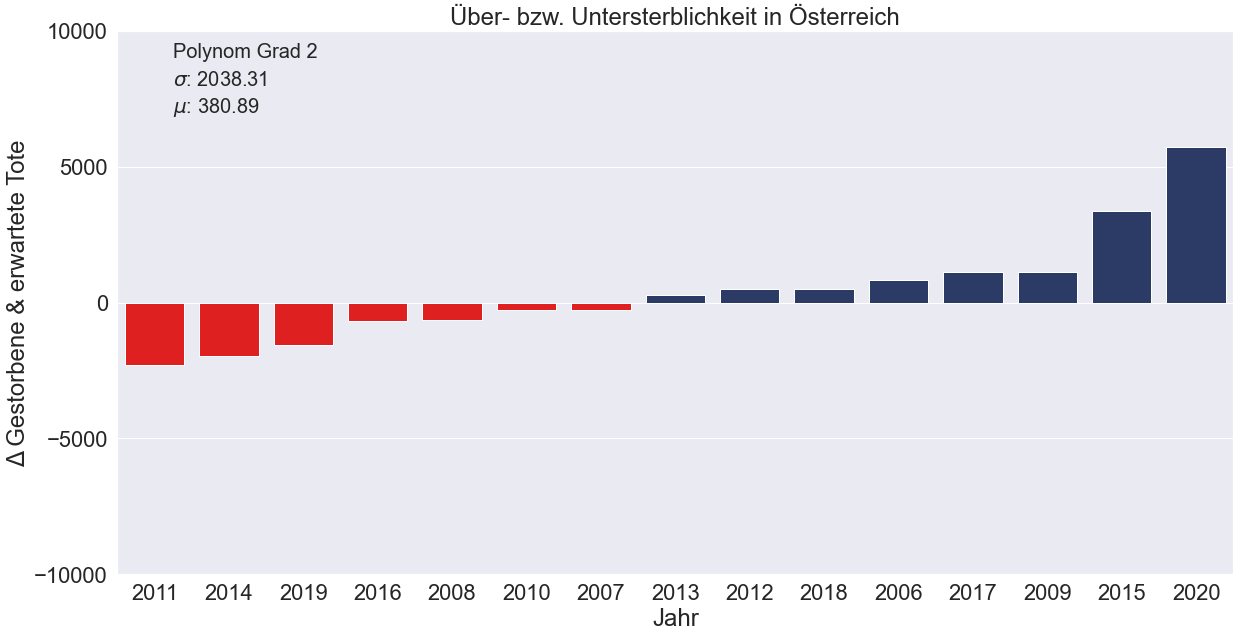

In [144]:
clrs = ['red' if y<=0 else hs_blau for y in df_2016_bis_2020_at_sorted.Delta_erwartet_altersbereinigt]
barplot_todesfaelle_at = sns.barplot(data = df_2016_bis_2020_at, x= "Jahr", y = "Delta_erwartet_altersbereinigt", order = years_sorted_by_delta, palette=clrs)
sns.set(font_scale=2)

barplot_todesfaelle_at.axes.annotate(f"$\mu$: {mean_delta_at:.2f}", xy=(0.05,0.85), xycoords='axes fraction', fontsize = 20)
barplot_todesfaelle_at.axes.annotate(f"$\sigma$: {std_delta_at:.2f}", xy=(0.05,0.9), xycoords='axes fraction', fontsize = 20)
barplot_todesfaelle_at.axes.annotate(f"Polynom Grad 2", xy=(0.05,0.95), xycoords='axes fraction', fontsize = 20)

barplot_todesfaelle_at.set_ylabel("Δ Gestorbene & erwartete Tote")
barplot_todesfaelle_at.set_xlabel("Jahr")
barplot_todesfaelle_at.set_title("Über- bzw. Untersterblichkeit in Österreich")
y1 = df_2016_bis_2020_at.Delta_erwartet_altersbereinigt
# plt.yticks(range(-40000, 50000, 10000))
plt.yticks(range(-10000, 15000, 5000))


plt.gcf().set_size_inches(20, 10)

## 7. Brechnung der Unter- und Übersterblichkeiten der Grippestarken Jahre

Ab hier muss noch alles überarbeitet werden .... Damit wir die Daten von 2003, 2009, 2013, 2015 2018

Bei der Verwendung von dem Jahr 2003 liegen leider keine 10 Vorjahr vor, da die Daten der Altersgruppen erst ab 2000 beginnen.

In [137]:
#Split in train und Test
lm_train_2003 = sterberaten_bereinigt_de.loc[(sterberaten_bereinigt_de["Jahr"] > 1999) & (sterberaten_bereinigt_de["Jahr"] < 2003)].reset_index(drop = True)
lm_train_2009 = sterberaten_bereinigt_de.loc[(sterberaten_bereinigt_de["Jahr"] > 1999) & (sterberaten_bereinigt_de["Jahr"] < 2009)].reset_index(drop = True)
lm_train_2013 = sterberaten_bereinigt_de.loc[(sterberaten_bereinigt_de["Jahr"] > 2002) & (sterberaten_bereinigt_de["Jahr"] < 2013)].reset_index(drop = True)
lm_train_2015 = sterberaten_bereinigt_de.loc[(sterberaten_bereinigt_de["Jahr"] > 2004) & (sterberaten_bereinigt_de["Jahr"] < 2015)].reset_index(drop = True)
lm_train_2018 = sterberaten_bereinigt_de.loc[(sterberaten_bereinigt_de["Jahr"] > 2007) & (sterberaten_bereinigt_de["Jahr"] < 2018)].reset_index(drop = True)
lm_train_2019 = sterberaten_bereinigt_de.loc[(sterberaten_bereinigt_de["Jahr"] > 2008) & (sterberaten_bereinigt_de["Jahr"] < 2019)].reset_index(drop = True)
lm_train_2019

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2018,1197.3936287451,994066.7670963550,954874.0000000000
1,2017,1188.1074317455,983662.0751478324,932262.9999999999
2,2016,1179.4440928749,973296.7616512571,910899.0000000000
3,2015,1224.6695491937,1006380.5787896229,925199.9999999999
4,2014,1173.9000831029,953177.9543204965,868356.0000000001
5,2013,1245.7842657022,1006188.3458608260,893825.0000000000
6,2012,1234.3103174342,993912.9048625464,869582.0000000000
7,2011,1233.6024270876,990926.9240285283,852328.0000000000
8,2010,1235.1500020187,1009754.9137532924,858768.0000000000
9,2009,1265.8937671366,1035529.6727400314,854543.9999999999


Im nächsten Schritt werden die Daten aufbereitet. Dafür müssen zunächst die Daten in einen neuen Dataframe Kopiert werden und diese anschließend nach den Jahren zu sortieren. 

In [138]:
df_2003 = lm_train_2003.copy().sort_values('Jahr').reset_index(drop= True)
df_2009 = lm_train_2009.copy().sort_values('Jahr').reset_index(drop= True)
df_2013 = lm_train_2013.copy().sort_values('Jahr').reset_index(drop= True)
df_2015 = lm_train_2015.copy().sort_values('Jahr').reset_index(drop= True)
df_2018 = lm_train_2018.copy().sort_values('Jahr').reset_index(drop= True)
df_2019 = lm_train_2019.copy().sort_values('Jahr').reset_index(drop= True)
df_2018

,Jahr,Sterberate_bereinigt,Todesfälle_altersbereinigt,Todesfälle_rohe
0,2008,1284.0405738689,1052943.5225684557,844439.0000000000
1,2009,1265.8937671366,1035529.6727400314,854543.9999999999
2,2010,1235.1500020187,1009754.9137532924,858768.0000000000
3,2011,1233.6024270876,990926.9240285283,852328.0000000000
4,2012,1234.3103174342,993912.9048625464,869582.0000000000
5,2013,1245.7842657022,1006188.3458608260,893825.0000000000
6,2014,1173.9000831029,953177.9543204965,868356.0000000001
7,2015,1224.6695491937,1006380.5787896229,925199.9999999999
8,2016,1179.4440928749,973296.7616512571,910899.0000000000
9,2017,1188.1074317455,983662.0751478324,932262.9999999999


In [139]:
##Erstellen der Trendline
coeff_2003_linear = np.polyfit(df_2003.Jahr, df_2003.Todesfälle_altersbereinigt ,1) # 1 = linear, 2 = x^2
coeff_2009_linear = np.polyfit(df_2009.Jahr, df_2009.Todesfälle_altersbereinigt ,1)
coeff_2013_linear = np.polyfit(df_2013.Jahr, df_2013.Todesfälle_altersbereinigt ,1)
coeff_2015_linear = np.polyfit(df_2015.Jahr, df_2015.Todesfälle_altersbereinigt ,1)
coeff_2018_linear = np.polyfit(df_2018.Jahr, df_2018.Todesfälle_altersbereinigt ,1)
coeff_2019_linear = np.polyfit(df_2019.Jahr, df_2019.Todesfälle_altersbereinigt ,1)


In [140]:
##Erstellen der Trendline polynom 2 Grades
coeff_2003_polynom_2 = np.polyfit(df_2003.Jahr, df_2003.Todesfälle_altersbereinigt ,2) # 1 = linear, 2 = x^2
coeff_2009_polynom_2 = np.polyfit(df_2009.Jahr, df_2009.Todesfälle_altersbereinigt ,2)
coeff_2013_polynom_2 = np.polyfit(df_2013.Jahr, df_2013.Todesfälle_altersbereinigt ,2)
coeff_2015_polynom_2 = np.polyfit(df_2015.Jahr, df_2015.Todesfälle_altersbereinigt ,2)
coeff_2018_polynom_2 = np.polyfit(df_2018.Jahr, df_2018.Todesfälle_altersbereinigt ,2)
coeff_2019_polynom_2 = np.polyfit(df_2019.Jahr, df_2019.Todesfälle_altersbereinigt ,2)

Berechnung der Erwartungswerte für die einzelnen Jahre von 2003 - 2018

In [141]:
pred_totesfaelle_2003_linear = np.polyval(coeff_2003_linear, 2003)  # adding a row
pred_totesfaelle_2009_linear = np.polyval(coeff_2009_linear, 2009)  
pred_totesfaelle_2013_linear = np.polyval(coeff_2013_linear, 2013)  
pred_totesfaelle_2015_linear = np.polyval(coeff_2015_linear, 2015)  
pred_totesfaelle_2018_linear = np.polyval(coeff_2018_linear, 2018)  
pred_totesfaelle_2019_linear = np.polyval(coeff_2019_linear, 2019)  

pred_totesfaelle_2003_polynom_2 = np.polyval(coeff_2003_polynom_2, 2003)  
pred_totesfaelle_2009_polynom_2 = np.polyval(coeff_2009_polynom_2, 2009)  
pred_totesfaelle_2013_polynom_2 = np.polyval(coeff_2013_polynom_2, 2013)  
pred_totesfaelle_2015_polynom_2 = np.polyval(coeff_2015_polynom_2, 2015)  
pred_totesfaelle_2018_polynom_2 = np.polyval(coeff_2018_polynom_2, 2018) 
pred_totesfaelle_2019_polynom_2 = np.polyval(coeff_2019_polynom_2, 2019) 

pred_totesfaelle_2019_polynom_2

1002857.4896907806

Brechnung des Bestimmtheitsmaß für die einzelnen Vorhersagen

In [142]:
# 2003 -2019
werte_2003_linear = pd.Series(np.polyval(coeff_2003_linear, df_2003.Jahr)).to_numpy()
werte_2003_polynom_2 = pd.Series(np.polyval(coeff_2003_polynom_2, df_2003.Jahr)).to_numpy()
werte_2009_linear = pd.Series(np.polyval(coeff_2009_linear, df_2009.Jahr)).to_numpy()
werte_2009_polynom_2 = pd.Series(np.polyval(coeff_2009_polynom_2, df_2009.Jahr)).to_numpy()
werte_2013_linear = pd.Series(np.polyval(coeff_2013_linear, df_2013.Jahr)).to_numpy()
werte_2013_polynom_2 = pd.Series(np.polyval(coeff_2013_polynom_2, df_2013.Jahr)).to_numpy()
werte_2015_linear = pd.Series(np.polyval(coeff_2015_linear, df_2015.Jahr)).to_numpy()
werte_2015_polynom_2 = pd.Series(np.polyval(coeff_2015_polynom_2, df_2015.Jahr)).to_numpy()
werte_2018_linear = pd.Series(np.polyval(coeff_2019_linear, df_2019.Jahr)).to_numpy()
werte_2018_polynom_2 = pd.Series(np.polyval(coeff_2018_polynom_2, df_2019.Jahr)).to_numpy()
werte_2019_linear = pd.Series(np.polyval(coeff_2019_linear, df_2019.Jahr)).to_numpy()
werte_2019_polynom_2 = pd.Series(np.polyval(coeff_2019_polynom_2, df_2019.Jahr)).to_numpy()

# 2003 -2019
bestimmtheitsmas_2003_linear = r2_score(df_2003.Todesfälle_altersbereinigt, werte_2003_linear)
bestimmtheitsmass_2003_polynom_2 = r2_score(df_2003.Todesfälle_altersbereinigt, werte_2003_polynom_2)
bestimmtheitsmas_2009_linear = r2_score(df_2009.Todesfälle_altersbereinigt, werte_2009_linear)
bestimmtheitsmass_2009_polynom_2 = r2_score(df_2009.Todesfälle_altersbereinigt, werte_2009_polynom_2)
bestimmtheitsmas_2013_linear = r2_score(df_2013.Todesfälle_altersbereinigt, werte_2013_linear)
bestimmtheitsmass_2013_polynom_2 = r2_score(df_2013.Todesfälle_altersbereinigt, werte_2013_polynom_2)
bestimmtheitsmas_2015_linear = r2_score(df_2015.Todesfälle_altersbereinigt, werte_2015_linear)
bestimmtheitsmass_2015_polynom_2 = r2_score(df_2015.Todesfälle_altersbereinigt, werte_2015_polynom_2)
bestimmtheitsmas_2018_linear = r2_score(df_2018.Todesfälle_altersbereinigt, werte_2018_linear)
bestimmtheitsmass_2018_polynom_2 = r2_score(df_2018.Todesfälle_altersbereinigt, werte_2018_polynom_2)
bestimmtheitsmas_2019_linear = r2_score(df_2019.Todesfälle_altersbereinigt, werte_2019_linear)
bestimmtheitsmass_2019_polynom_2 = r2_score(df_2019.Todesfälle_altersbereinigt, werte_2019_polynom_2)
bestimmtheitsmass_2019_polynom_2

0.5155074540777425

### Erweiterung der Datensätze um den ermittelten Wert

In [143]:
df_2003_bis_2019 = sterberaten_bereinigt.loc[(sterberaten_bereinigt.Jahr == 2003) | (sterberaten_bereinigt.Jahr == 2009) | (sterberaten_bereinigt.Jahr == 2013) | (sterberaten_bereinigt.Jahr == 2015) | (sterberaten_bereinigt.Jahr == 2018) | (sterberaten_bereinigt.Jahr == 2019)].sort_values("Jahr").reset_index(drop=True)
df_2003_bis_2019

NameError: name 'sterberaten_bereinigt' is not defined

___________________________


In [ ]:
bestimmtheitsmas_2019_linear

0.29417082059117416

In [ ]:
bestimmtheitsmass_2019_polynom_2

0.5155074540777425

Darstellung der Trendlinien

In [ ]:

df_2019 = df_2019.append({'Jahr' : int(2019), 'Todesfälle_altersbereinigt' : df_2003_bis_2019.Todesfälle_altersbereinigt[5]} , ignore_index=True)
df_2019 = df_2019.drop(columns=['Sterberate_bereinigt', 'Todesfälle_rohe'])
df_2019

C:\Users\mikes\AppData\Local\Temp\ipykernel_25804\3554636278.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2019 = df_2019.append({'Jahr' : int(2019), 'Todesfälle_altersbereinigt' : df_2003_bis_2019.Todesfälle_altersbereinigt[5]} , ignore_index=True)


,Jahr,Todesfälle_altersbereinigt
0,2009.0000,1035529.6727
1,2010.0000,1009754.9138
2,2011.0000,990926.9240
3,2012.0000,993912.9049
4,2013.0000,1006188.3459
5,2014.0000,953177.9543
6,2015.0000,1006380.5788
7,2016.0000,973296.7617
8,2017.0000,983662.0751
9,2018.0000,994066.7671


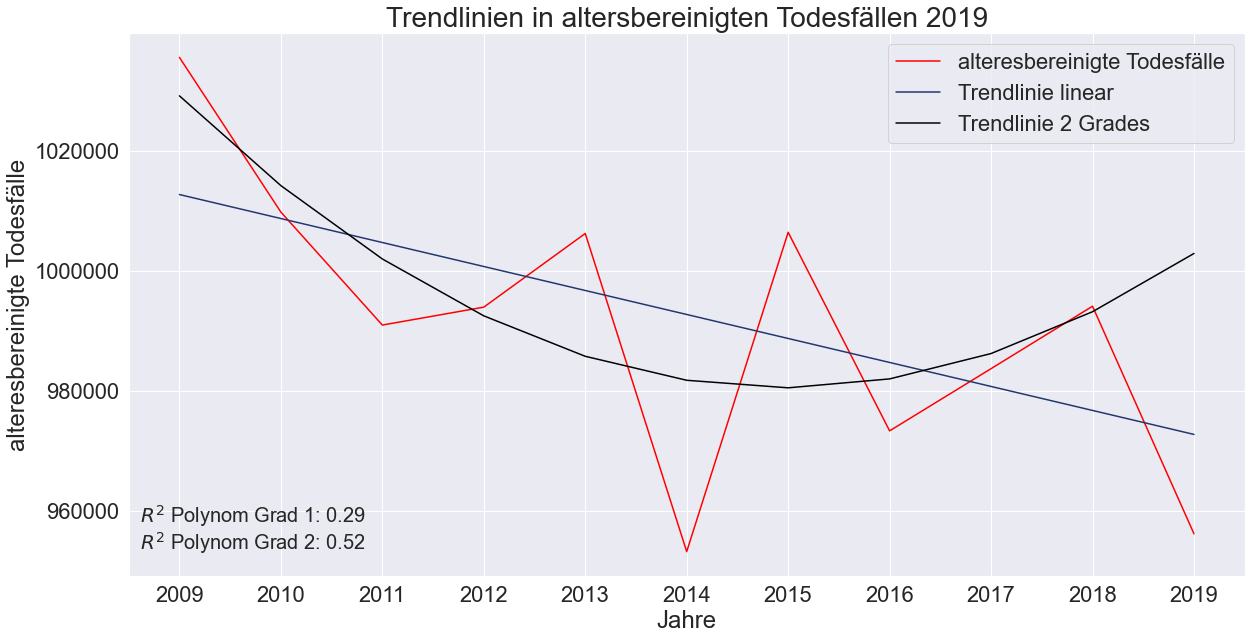

In [ ]:
df_2019['predicted'] = pd.Series(np.polyval(coeff_2019_linear, df_2019.Jahr))
df_2019['predicted_2'] = pd.Series(np.polyval(coeff_2019_polynom_2, df_2019.Jahr))
sns.set(font_scale=2)


ax = sns.lineplot(x="Jahr",  y='Todesfälle_altersbereinigt', data=df_2019, color ="red")
plot_linear = sns.lineplot(ax=ax, x="Jahr",  y='predicted', data=df_2019, color=hs_blau)
plot_polynom_2_Grades = sns.lineplot(ax=plot_linear, x="Jahr",  y='predicted_2', data=df_2019, color="black")


# plot_linear2.fill_between(x=df.Jahr,y1=df.predicted, y2=df.Todesfälle_altersbereinigt, where=(df.predicted > df.Todesfälle_altersbereinigt),color= "#22376f", alpha=0.9, interpolate=True)
# plot_linear2.fill_between(x=df.Jahr,y1=df.predicted, y2=df.Todesfälle_altersbereinigt, where=(df.predicted <= df.Todesfälle_altersbereinigt),color= "#df2020", alpha=0.9, interpolate=True)

plt.legend(labels=['alteresbereinigte Todesfälle', "Trendlinie linear", 'Trendlinie 2 Grades',])
sns.set_theme(style="whitegrid")

plot_linear.axes.annotate(f"$R^2$ Polynom Grad 1: {bestimmtheitsmas_2019_linear:.2f}", xy=(0.01,0.1), xycoords='axes fraction', fontsize = 20)
plot_linear.axes.annotate(f"$R^2$ Polynom Grad 2: {bestimmtheitsmass_2019_polynom_2:.2f}", xy=(0.01,0.05), xycoords='axes fraction', fontsize = 20)


plot_linear.set_title("Trendlinien in altersbereinigten Todesfällen 2019", fontsize= 28)
plot_linear.ticklabel_format(axis="y", style="plain")
plot_linear.set_ylabel("alteresbereinigte Todesfälle")
plot_linear.set_xlabel("Jahre")
plt.xticks(range(2009, 2020, 1))

plt.gcf().set_size_inches(20, 10)


In [ ]:
plot_linear = plot_linear.get_figure()
plot_linear.savefig("Trendlinien_in_altersbereinigten_Todesfällen_2019.png", dpi=200)

________________________________


In [ ]:
polynom_2_werte_der_jahre = [pred_totesfaelle_2003_polynom_2, pred_totesfaelle_2009_polynom_2, pred_totesfaelle_2013_polynom_2, pred_totesfaelle_2015_polynom_2, pred_totesfaelle_2018_polynom_2, pred_totesfaelle_2019_polynom_2]
polynom_2_werte_der_jahre

[1222611.9536895752,
 1012526.3000450134,
 997506.156003952,
 955599.39162907,
 993713.0908412933,
 1002857.4896907806]

In [ ]:
lineare_werte_der_jahre = [pred_totesfaelle_2003_linear, pred_totesfaelle_2009_linear, pred_totesfaelle_2013_linear, pred_totesfaelle_2015_linear, pred_totesfaelle_2018_linear, pred_totesfaelle_2019_linear]
polynom_2_werte_der_jahre = [pred_totesfaelle_2003_polynom_2, pred_totesfaelle_2009_polynom_2, pred_totesfaelle_2013_polynom_2, pred_totesfaelle_2015_polynom_2, pred_totesfaelle_2018_polynom_2, pred_totesfaelle_2019_polynom_2]
zeitspanne = [2003,2009,2013,2015,2018,2019]


df_delta_erwartungswerte = {"Jahr": zeitspanne, "Todesfälle_altersbereinigt": df_2003_bis_2019.Todesfälle_altersbereinigt , "Erwartete_Todesfälle_linear": lineare_werte_der_jahre, "Erwartete_Todesfälle_polynom_2": polynom_2_werte_der_jahre}
df_delta_erwartungswerte = pd.DataFrame(df_delta_erwartungswerte) 
df_delta_erwartungswerte["Delta_erwartet_altersbereinigt_linear"] = df_2003_bis_2019["Todesfälle_altersbereinigt"] - df_delta_erwartungswerte["Erwartete_Todesfälle_linear"]
df_delta_erwartungswerte["Delta_erwartet_altersbereinigt_polynom_2"] = df_2003_bis_2019["Todesfälle_altersbereinigt"] - df_delta_erwartungswerte["Erwartete_Todesfälle_polynom_2"]
df_delta_erwartungswerte

,Jahr,Todesfälle_altersbereinigt,Erwartete_Todesfälle_linear,Erwartete_Todesfälle_polynom_2,Delta_erwartet_altersbereinigt_linear,Delta_erwartet_altersbereinigt_polynom_2
0,2003,1177630.1910,1153130.1408,1222611.9537,24500.0502,-44981.7627
1,2009,1035529.6727,1016889.8834,1012526.3000,18639.7893,23003.3727
2,2013,1006188.3459,960772.7559,997506.1560,45415.5900,8682.1899
3,2015,1006380.5788,956577.6165,955599.3916,49802.9623,50781.1872
4,2018,994066.7671,961343.8138,993713.0908,32722.9533,353.6763
5,2019,956145.7247,972703.8831,1002857.4897,-16558.1584,-46711.7650


### Verschmelzen 2er Variablen, um sie in einem Plot darzustellen

Berechnung der Abweichung der geschätzten Werte von dem eigentlichen Daten  

In [ ]:
val_data = df_delta_erwartungswerte.Todesfälle_altersbereinigt
val_preds_linear = df_delta_erwartungswerte.Erwartete_Todesfälle_linear
val_preds_poly_2 = df_delta_erwartungswerte.Erwartete_Todesfälle_polynom_2

mean_abs_err_linear = np.mean(abs(val_data - val_preds_linear))
mean_abs_err_poly_2 = np.mean(abs(val_data - val_preds_poly_2))
mean_abs_err_poly_2

est_exc_deaths_linear = (np.sum(val_data) / np.sum(val_preds_linear) - 1) * 100
est_exc_deaths_poly_2 = (np.sum(val_data) / np.sum(val_preds_poly_2) - 1) * 100
est_exc_deaths_linear

2.5662258355456213

In [ ]:
df_delta_erwartungswerte_melted = pd.melt(df_delta_erwartungswerte, id_vars=['Jahr'], value_vars=['Todesfälle_altersbereinigt','Erwartete_Todesfälle_linear',"Erwartete_Todesfälle_polynom_2"], var_name='')

([<matplotlib.axis.YTick at 0x1f69c3a9360>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

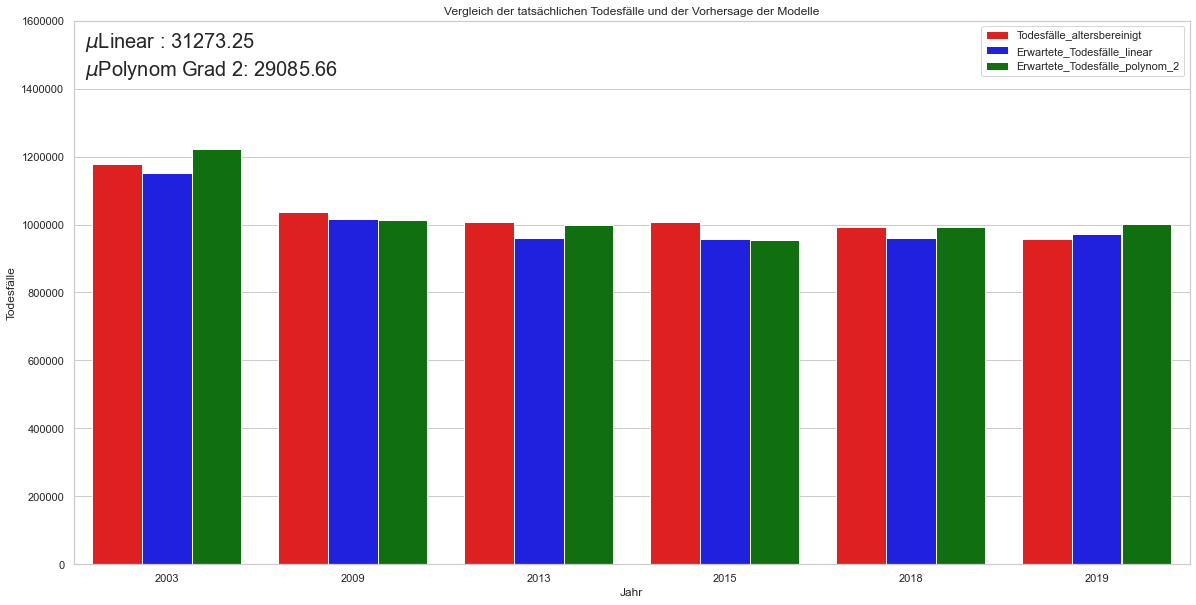

In [ ]:
clrs = ["red", "blue", "green"]

df_delta_erwartungswerte_melted_barplot = sns.barplot(x="Jahr", y="value", hue="", data=df_delta_erwartungswerte_melted, palette=clrs)
plt.ticklabel_format(style='plain', axis='y')
df_delta_erwartungswerte_melted_barplot.set_ylabel("Todesfälle")
df_delta_erwartungswerte_melted_barplot.set_xlabel("Jahr")
df_delta_erwartungswerte_melted_barplot.set_title("Vergleich der tatsächlichen Todesfälle und der Vorhersage der Modelle")


df_delta_erwartungswerte_melted_barplot.axes.annotate(f"$\mu$Linear : {mean_abs_err_linear:.2f}", xy=(0.01,0.95), xycoords='axes fraction', fontsize = 20)
df_delta_erwartungswerte_melted_barplot.axes.annotate(f"$\mu$Polynom Grad 2: {mean_abs_err_poly_2:.2f}", xy=(0.01,0.9), xycoords='axes fraction', fontsize = 20)

plt.gcf().set_size_inches(20,10 )
sns.set(font_scale=2)
plt.yticks(range(0, 1800000, 200000))

In [ ]:
df_delta_erwartungswerte_melted_barplot = df_delta_erwartungswerte_melted_barplot.get_figure()
df_delta_erwartungswerte_melted_barplot.savefig("Vergleich_der_tatsächlichen_Todesfälle_und_der_Vorhersage_der_Modelle.png", dpi=200)

Erstellen eines Raking für die Darstellung der Schätzung

In [ ]:
#linear
df_2003_bis_2019_sorted_linear  = df_delta_erwartungswerte.sort_values(by=["Delta_erwartet_altersbereinigt_linear"]).reset_index(drop= True)
years_sorted_by_delta_linear = df_2003_bis_2019_sorted_linear["Jahr"].to_list()
years_sorted_by_delta_linear

[2019, 2009, 2003, 2018, 2013, 2015]

In [ ]:
#Polynom 2 Grades
df_2003_bis_2019_sorted_polynom_2  = df_delta_erwartungswerte.sort_values(by=["Delta_erwartet_altersbereinigt_polynom_2"]).reset_index(drop= True)
years_sorted_by_delta_polynom_2 = df_2003_bis_2019_sorted_polynom_2["Jahr"].to_list()
years_sorted_by_delta_polynom_2

[2019, 2003, 2018, 2013, 2009, 2015]

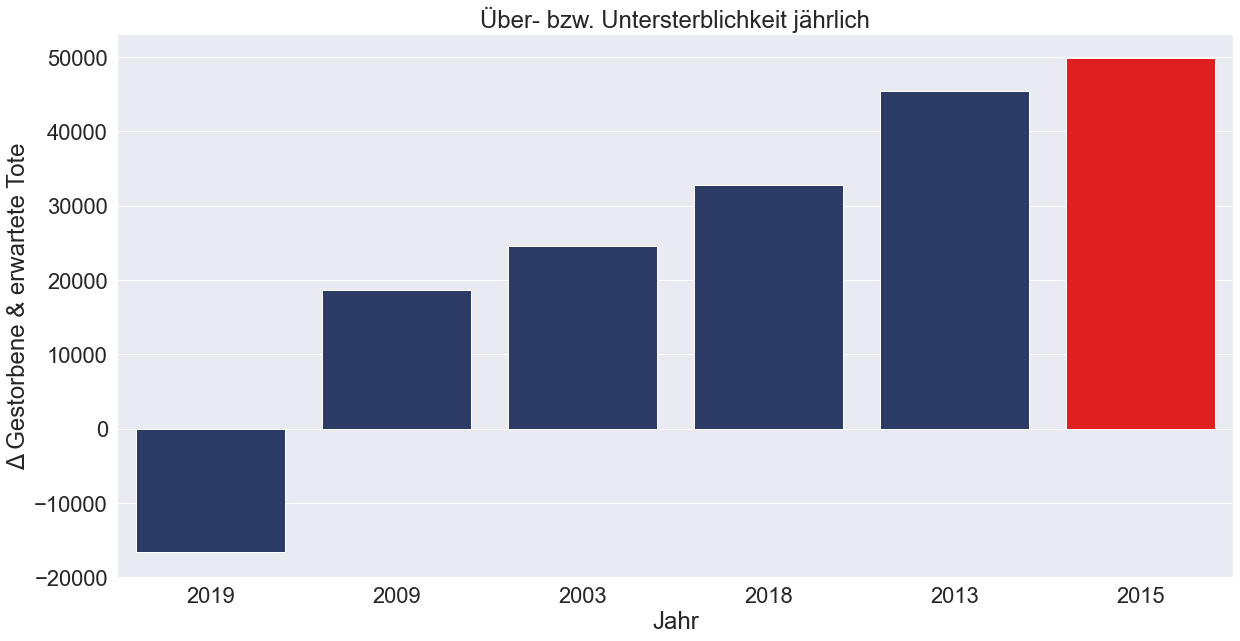

In [ ]:
clrs = ['red' if y<=0 else hs_blau for y in df_delta_erwartungswerte.Delta_erwartet_altersbereinigt_linear]


barplot_todesfaelle_sorted_linear = sns.barplot(data = df_delta_erwartungswerte, x= df_delta_erwartungswerte.Jahr, y = df_delta_erwartungswerte.Delta_erwartet_altersbereinigt_linear, order = years_sorted_by_delta_linear, palette=clrs)
sns.set(font_scale=2)



barplot_todesfaelle_sorted_linear.set_ylabel("Δ Gestorbene & erwartete Tote")
barplot_todesfaelle_sorted_linear.set_xlabel("Jahr")
barplot_todesfaelle_sorted_linear.set_title("Über- bzw. Untersterblichkeit jährlich")

plt.yticks(range(-20000, 60000, 10000))
plt.gcf().set_size_inches(20, 10)

Plot Polynom zweiten grades

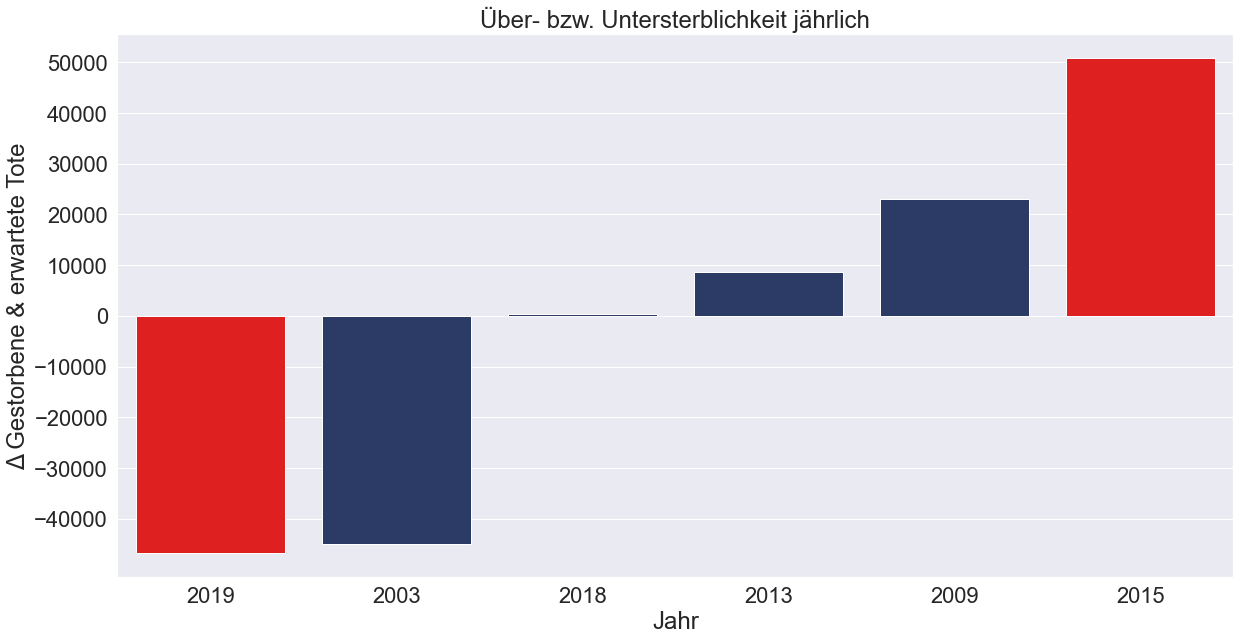

In [ ]:
clrs = ['red' if y<=0 else hs_blau for y in df_delta_erwartungswerte.Delta_erwartet_altersbereinigt_polynom_2]


barplot_todesfaelle_sorted_polynom_2 = sns.barplot(data = df_delta_erwartungswerte, x= df_delta_erwartungswerte.Jahr, y = df_delta_erwartungswerte.Delta_erwartet_altersbereinigt_polynom_2, order = years_sorted_by_delta_polynom_2, palette=clrs)
sns.set(font_scale=2)


barplot_todesfaelle_sorted_polynom_2.set_ylabel("Δ Gestorbene & erwartete Tote")
barplot_todesfaelle_sorted_polynom_2.set_xlabel("Jahr")
barplot_todesfaelle_sorted_polynom_2.set_title("Über- bzw. Untersterblichkeit jährlich")

plt.yticks(range(-40000, 60000, 10000))


plt.gcf().set_size_inches(20, 10)

### Sicherung der Grafiken 

In [ ]:
ax = ax.get_figure()
ax.savefig("rohe_vs_altersbereingte_sterblichkeit.png", dpi=200)

In [ ]:
plot_linear2 = plot_linear2.get_figure()
plot_linear2.savefig("Trendlinien_in_altersbereinigten_Todesfällen.png", dpi=200)

In [ ]:
plot_linear = plot_linear.get_figure()
plot_linear.savefig("plot_linear.png", dpi=200)

In [ ]:
barplot_todesfaelle_sorted = barplot_todesfaelle_sorted.get_figure()
barplot_todesfaelle_sorted.savefig("plot_linear.png", dpi=200)